In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

import xgboost as xgb
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder


import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/data/home/achmad.firmansyah/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size, condition="backscatter"):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    if(condition=="backscatter"):
        X = df.loc[:,'VH_30':'VH_0']
        # X = df.loc[:,'VH_10':'VH_0']
    elif(condition=="features"):
        X = df.loc[:,'F1':'F17']
    elif(condition=="all"):
        X = df.loc[:,'VH_0':'F17']
    else: 
        print("set the condition")
        return None
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 2
    class_2_mask = (y_true == 2)
    if np.any(class_2_mask):  # Check if class 2 is present in the true labels
        return accuracy_score(y_true[class_2_mask], y_pred[class_2_mask])
    else:
        return 0.0  # Return 0 if class 2 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 0, 1, 2, and 3
    class_0123_mask = (y_true >= 0) & (y_true <= 3)
    if np.any(class_0123_mask):  # Check if classes 0, 1, 2, or 3 are present in the true labels
        return accuracy_score(y_true[class_0123_mask], y_pred[class_0123_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

def evaluate_model(X_train, y_train, X_test, y_test, best_params=None, n_splits=5):
    # Convert data to DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    if best_params is None:
        params = {
            "objective": "multi:softprob",  # or "multi:softmax" if you want the class labels directly
            "eval_metric": ['merror', 'auc', 'mlogloss'],
            "num_class": len(set(y_train)),  # Number of classes in the target variable
            "max_depth": 6,
            "eta": 0.3,
            "verbosity": 1, 
            "nthread": 8
        }
    else:
        print("Best parameters: " + str(best_params))
        params = {
            "objective": "multi:softprob",  # Use softprob to get probabilities for each class
            "eval_metric": ['merror', 'mlogloss'],  # Evaluation metrics
            "num_class": len(set(y_train)),  # Number of classes
            "nthread": 8,
            **best_params  # Unpack the best parameters from Optuna
        }

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        model = xgb.train(params, dtrain_fold, num_boost_round=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    # Final model evaluation on the test set
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[0, 0:2]) + sum(cm[0, 4:5]) + sum(cm[1, 0:3]) + sum(cm[2, 1:4]) + sum(cm[3, 2:5]) + sum(cm[4, 3:5]) + sum(cm[4, 0:1])) / sum(sum(cm[0:5, 0:5]))

    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

##  Unrecode

In [3]:
## Read VH dataset
kdprov='32'
df_fin=pd.read_pickle(f'/data/ksa/04_Data_Preprocessing/training-test/32/training_32_VH_unrecode_imputation_var20.pkl')
print(df_fin.shape)
df_fin.head(2)

(631750, 42)


,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,year,date,Sigma0VH_variance,flag_variance_Q20
0,320201009C1#01,320201009C1,320201009,1,2022_03,3,48MXS,-14.566465,-14.238100,-15.280122,...,-13.836024,-14.264042,-14.220155,-14.081954,-15.385819,-14.512360,22,2022-01-01,0.245499,1
1,320201009C1#02,320201009C1,320201009,1,2022_03,3,48MXS,-14.742791,-14.646698,-14.321390,...,-14.043587,-13.841569,-14.035186,-14.236593,-14.159606,-13.999538,22,2022-01-01,0.245499,1


In [4]:
df = df_fin.copy()
df['observation'] = df['observation'].astype('float64').astype('int')

In [5]:
df['observation'].unique()

array([3, 2, 7, 8, 4, 5, 1, 6])

[3 2 7 8 4 5 1]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73     31357
           1       0.67      0.66      0.66     24323
           2       0.70      0.71      0.71     34792
           3       0.68      0.72      0.70     43680
           4       0.72      0.51      0.59     17588
           5       0.45      0.69      0.54     24360
           6       0.49      0.17      0.26     13050

    accuracy                           0.65    189150
   macro avg       0.64      0.60      0.60    189150
weighted avg       0.66      0.65      0.64    189150



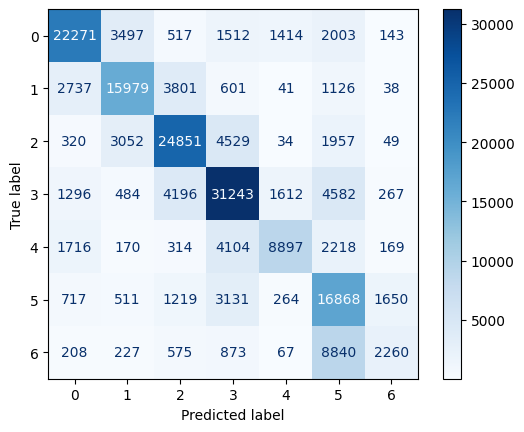

{'average_accuracy': 0.6479891242777841, 'average_f1_macro': np.float64(0.6011001965857103), 'average_f1_micro': np.float64(0.6479891242777841), 'average_auc': np.float64(0.9233780933980766), 'average_acc_kelas_generatif': 0.7129201024131603, 'average_acc_fase_padi': 0.7043380231172655}
{'val_accuracy': 0.6469415807560137, 'val_f1_macro': np.float64(0.5995872184088801), 'val_f1_micro': np.float64(0.6469415807560137), 'val_auc': np.float64(0.9228373504617547), 'val_acc_kelas_generatif': 0.7142733961830305, 'val_acc_fase_padi': 0.7032619714950206, 'val_relative_acc': np.float64(96.20010345719459)}


In [8]:
df = df.query('observation not in [6]')

X_train, X_test, y_train, y_test = get_train_test(df, 0.3, condition="backscatter")

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(np.unique(y_train_encoded))

class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping of original to encoded classes:", class_mapping)

model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
    X_train, y_train_encoded, X_test, y_test_encoded)

print(training_metrics0)
print(validation_metrics0)

# Define per cluster

In [9]:
import geopandas as gpd
data_cluster=gpd.read_file(f'/data/ksa/00_Data_Input/cluster_data/cluster_{kdprov}_ok.gpkg')

In [10]:
df['idkab']=df.idsubsegment.apply(lambda y: str(y)[:4])

In [11]:
df=df.merge(
    data_cluster[['idkab','cluster_data']],left_on='idkab',right_on='idkab')

/tmp/ipykernel_851377/2727667970.py:1: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))


<Axes: xlabel='observation', ylabel='count'>

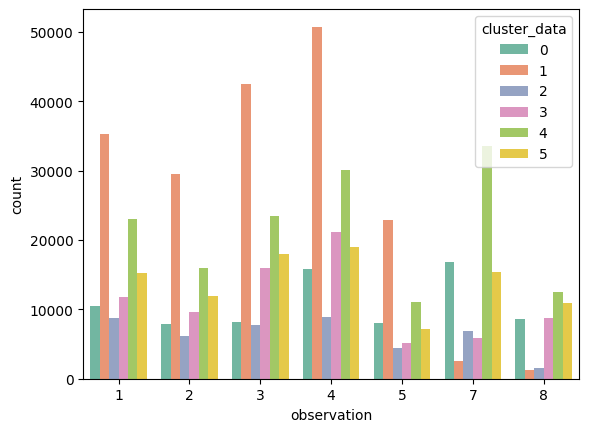

In [12]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))

# Running per Cluster

CLUSTER:  0


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[8 5 1 2 7 4 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      3128
           1       0.76      0.71      0.74      2347
           2       0.75      0.72      0.73      2452
           3       0.77      0.75      0.76      4733
           4       0.83      0.64      0.72      2430
           5       0.57      0.83      0.68      5070
           6       0.58      0.28      0.38      2573

    accuracy                           0.70     22733
   macro avg       0.73      0.68      0.69     22733
weighted avg       0.71      0.70      0.70     22733



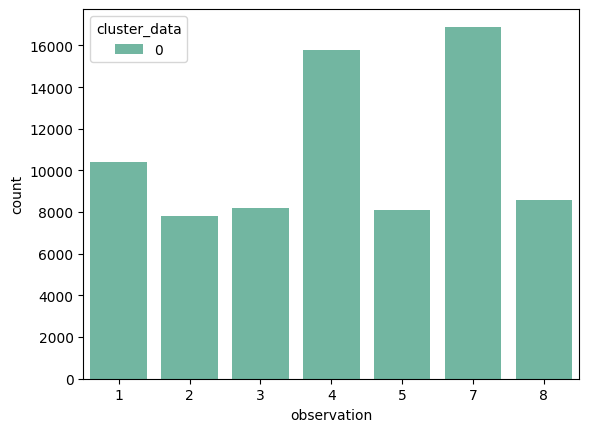

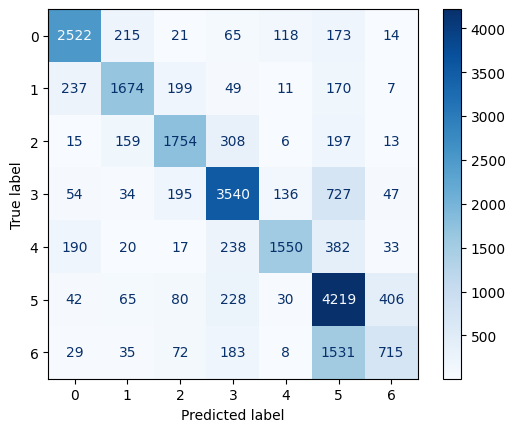

{'average_accuracy': 0.7014252782328445, 'average_f1_macro': np.float64(0.6871465834882375), 'average_f1_micro': np.float64(0.7014252782328445), 'average_auc': np.float64(0.9368617634206796), 'average_acc_kelas_generatif': 0.711338137844688, 'average_acc_fase_padi': 0.7506093432633717}
{'val_accuracy': 0.7026789249109224, 'val_f1_macro': np.float64(0.6874852793482878), 'val_f1_micro': np.float64(0.7026789249109224), 'val_auc': np.float64(0.9373436106769981), 'val_acc_kelas_generatif': 0.7153344208809136, 'val_acc_fase_padi': 0.7496050552922591, 'val_relative_acc': np.float64(97.80895925564643)}
CLUSTER:  4


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[3 2 7 8 4 5 1]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      6893
           1       0.66      0.64      0.65      4800
           2       0.65      0.66      0.66      7058
           3       0.62      0.62      0.62      9015
           4       0.65      0.36      0.46      3307
           5       0.52      0.78      0.62     10080
           6       0.50      0.15      0.23      3765

    accuracy                           0.61     44918
   macro avg       0.62      0.55      0.56     44918
weighted avg       0.62      0.61      0.60     44918



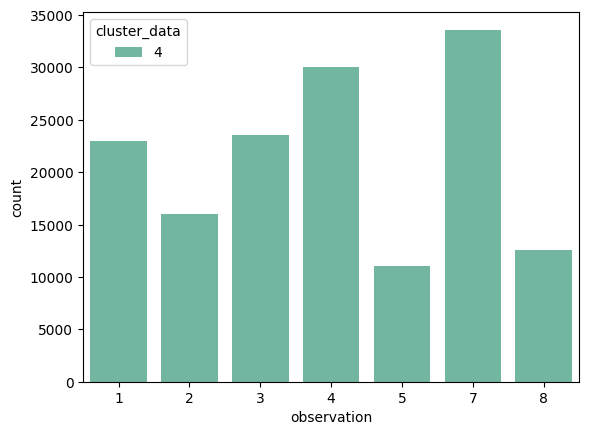

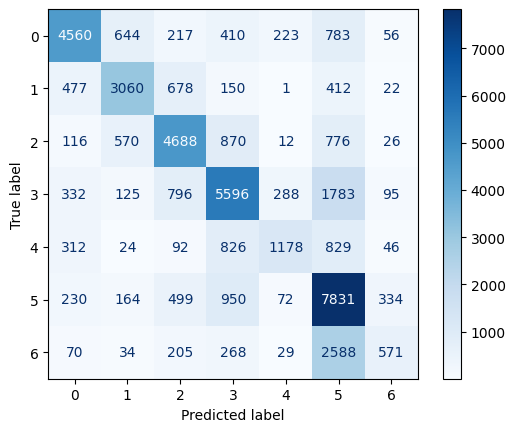

{'average_accuracy': 0.6109229870343942, 'average_f1_macro': np.float64(0.5639400426628262), 'average_f1_micro': np.float64(0.6109229870343942), 'average_auc': np.float64(0.8956828225416213), 'average_acc_kelas_generatif': 0.664723205430518, 'average_acc_fase_padi': 0.6428593159557405}
{'val_accuracy': 0.611870519613518, 'val_f1_macro': np.float64(0.5638765498781618), 'val_f1_micro': np.float64(0.611870519613518), 'val_auc': np.float64(0.895382748871954), 'val_acc_kelas_generatif': 0.6642108245962028, 'val_acc_fase_padi': 0.6448174025786934, 'val_relative_acc': np.float64(94.3646408839779)}
CLUSTER:  5


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[8 1 2 7 5 4 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      4553
           1       0.72      0.67      0.69      3592
           2       0.73      0.73      0.73      5408
           3       0.68      0.73      0.70      5685
           4       0.74      0.46      0.57      2130
           5       0.51      0.62      0.56      4613
           6       0.62      0.63      0.62      3262

    accuracy                           0.67     29243
   macro avg       0.68      0.65      0.66     29243
weighted avg       0.68      0.67      0.67     29243



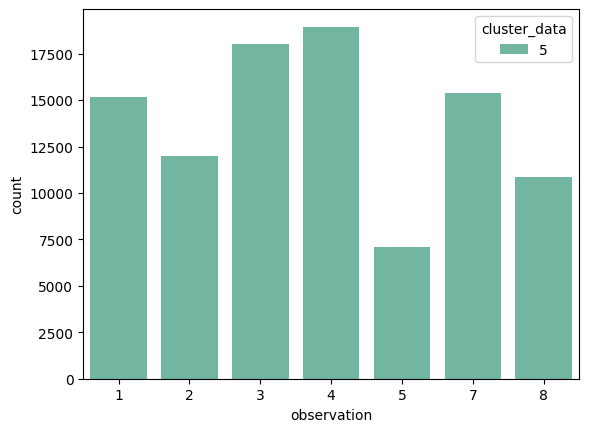

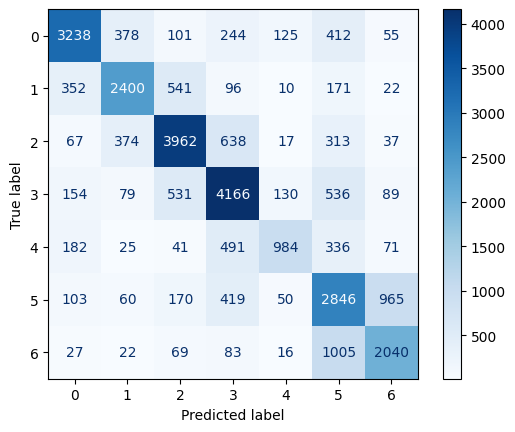

{'average_accuracy': 0.6694365770730878, 'average_f1_macro': np.float64(0.658306823462594), 'average_f1_micro': np.float64(0.6694365770730878), 'average_auc': np.float64(0.9318437369659941), 'average_acc_kelas_generatif': 0.7335346821916655, 'average_acc_fase_padi': 0.7130794513530321}
{'val_accuracy': 0.6714769346510276, 'val_f1_macro': np.float64(0.660644166056853), 'val_f1_micro': np.float64(0.6714769346510276), 'val_auc': np.float64(0.9323742503402795), 'val_acc_kelas_generatif': 0.7326183431952663, 'val_acc_fase_padi': 0.7155629483314274, 'val_relative_acc': np.float64(95.68457000931387)}
CLUSTER:  3


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[8 3 2 1 5 4 7]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      3540
           1       0.70      0.69      0.69      2873
           2       0.69      0.76      0.72      4808
           3       0.67      0.77      0.72      6368
           4       0.70      0.36      0.47      1545
           5       0.50      0.23      0.31      1762
           6       0.51      0.64      0.57      2617

    accuracy                           0.66     23513
   macro avg       0.64      0.59      0.60     23513
weighted avg       0.66      0.66      0.65     23513



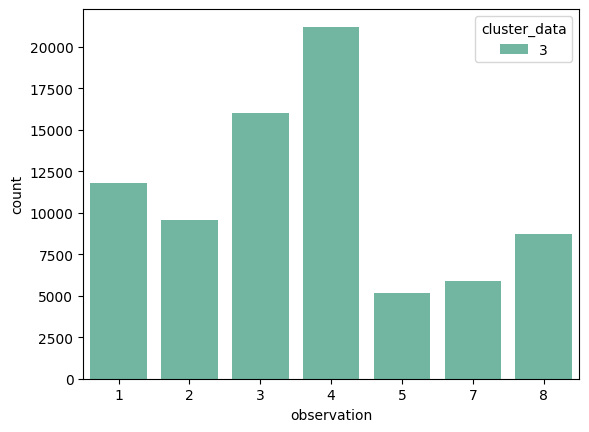

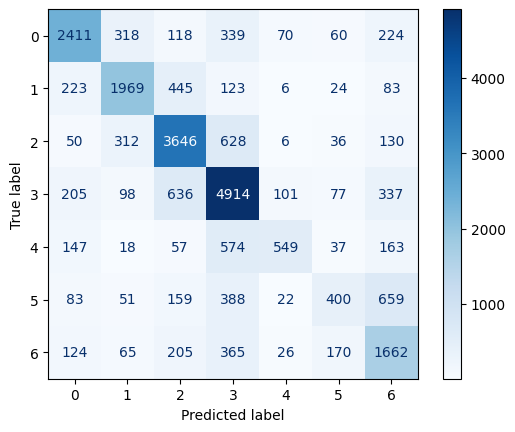

{'average_accuracy': 0.6616054672226154, 'average_f1_macro': np.float64(0.5986942997892932), 'average_f1_micro': np.float64(0.6616054672226154), 'average_auc': np.float64(0.9183764417807113), 'average_acc_kelas_generatif': 0.7522524026025115, 'average_acc_fase_padi': 0.7352569588795618}
{'val_accuracy': 0.6613788117211755, 'val_f1_macro': np.float64(0.5989100525190906), 'val_f1_micro': np.float64(0.6613788117211755), 'val_auc': np.float64(0.9183519985570756), 'val_acc_kelas_generatif': 0.7583194675540765, 'val_acc_fase_padi': 0.7356870771504918, 'val_relative_acc': np.float64(94.32166119245115)}
CLUSTER:  2


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[2 5 7 8 1 4 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2647
           1       0.75      0.73      0.74      1837
           2       0.80      0.81      0.81      2325
           3       0.74      0.74      0.74      2655
           4       0.73      0.57      0.64      1313
           5       0.57      0.73      0.64      2085
           6       0.59      0.30      0.40       458

    accuracy                           0.73     13320
   macro avg       0.71      0.67      0.68     13320
weighted avg       0.73      0.73      0.72     13320



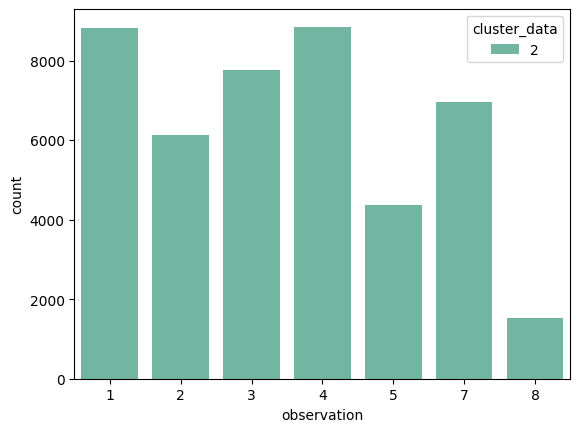

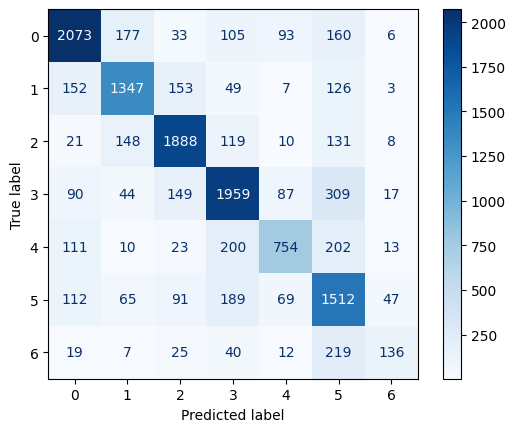

{'average_accuracy': 0.7228442728442729, 'average_f1_macro': np.float64(0.6761109442884996), 'average_f1_micro': np.float64(0.7228442728442729), 'average_auc': np.float64(0.9473926018265445), 'average_acc_kelas_generatif': 0.79963133640553, 'average_acc_fase_padi': 0.7607086513863214}
{'val_accuracy': 0.7259009009009009, 'val_f1_macro': np.float64(0.6790185178120118), 'val_f1_micro': np.float64(0.7259009009009009), 'val_auc': np.float64(0.9483233568259825), 'val_acc_kelas_generatif': 0.8120430107526881, 'val_acc_fase_padi': 0.7678571428571429, 'val_relative_acc': np.float64(96.00081615996736)}
CLUSTER:  1


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 3 5 8 4 7]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(6)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     10597
           1       0.80      0.81      0.81      8872
           2       0.82      0.83      0.83     12743
           3       0.84      0.88      0.86     15225
           4       0.84      0.80      0.82      6863
           5       0.46      0.17      0.25       750
           6       0.59      0.37      0.45       375

    accuracy                           0.83     55425
   macro avg       0.75      0.68      0.70     55425
weighted avg       0.83      0.83      0.83     55425



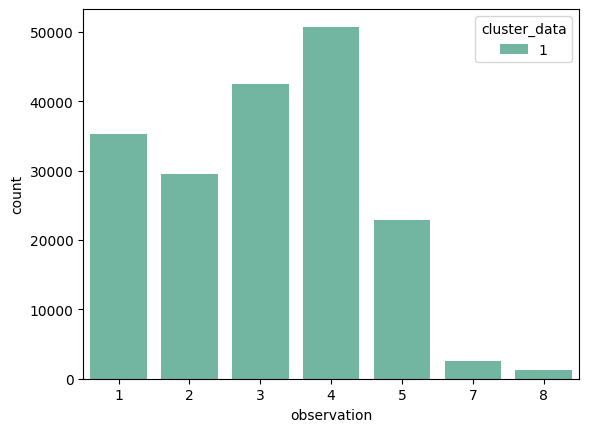

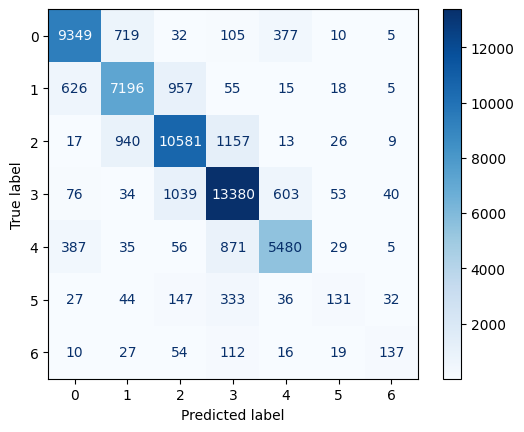

{'average_accuracy': 0.8360564469360139, 'average_f1_macro': np.float64(0.707907805613103), 'average_f1_micro': np.float64(0.8360564469360139), 'average_auc': np.float64(0.9788569331076518), 'average_acc_kelas_generatif': 0.8373134795186837, 'average_acc_fase_padi': 0.856732411013238}
{'val_accuracy': 0.8345331529093369, 'val_f1_macro': np.float64(0.6994872578105911), 'val_f1_micro': np.float64(0.8345331529093369), 'val_auc': np.float64(0.9771757079065545), 'val_acc_kelas_generatif': 0.8303382249077925, 'val_acc_fase_padi': 0.8538904230874633, 'val_relative_acc': np.float64(99.19038817005546)}


In [14]:
for i in data_cluster.cluster_data.unique():
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded)
    print(training_metrics0)
    print(validation_metrics0)

In [15]:
df['observation']=df.observation.apply(lambda y: 7 if y>7 else y)

/tmp/ipykernel_851377/2727667970.py:1: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))


<Axes: xlabel='observation', ylabel='count'>

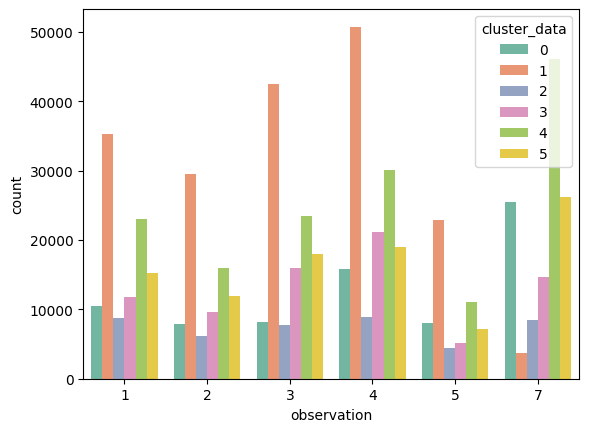

In [16]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))

CLUSTER:  0


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 5 1 2 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      3128
           1       0.76      0.70      0.73      2347
           2       0.77      0.71      0.74      2452
           3       0.78      0.73      0.76      4733
           4       0.84      0.63      0.72      2430
           5       0.78      0.92      0.85      7643

    accuracy                           0.79     22733
   macro avg       0.79      0.75      0.77     22733
weighted avg       0.79      0.79      0.79     22733



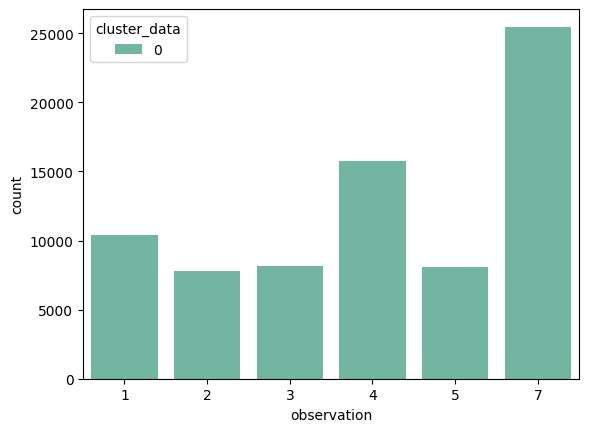

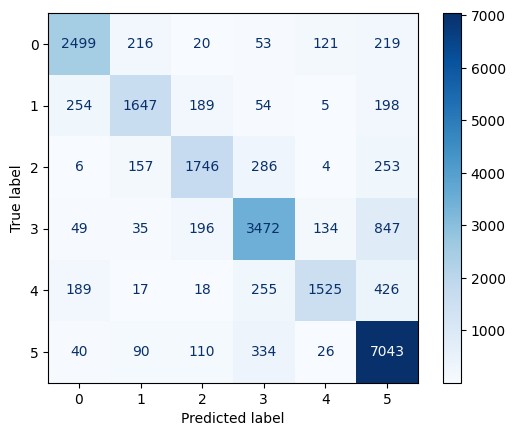

{'average_accuracy': 0.7884318228767032, 'average_f1_macro': np.float64(0.7661620950901482), 'average_f1_micro': np.float64(0.7884318228767032), 'average_auc': np.float64(0.9534611890405233), 'average_acc_kelas_generatif': 0.6991093840657159, 'average_acc_fase_padi': 0.7396411645226811}
{'val_accuracy': 0.7888092200765408, 'val_f1_macro': np.float64(0.7667953741557226), 'val_f1_micro': np.float64(0.7888092200765408), 'val_auc': np.float64(0.9551449605351395), 'val_acc_kelas_generatif': 0.7120717781402937, 'val_acc_fase_padi': 0.739652448657188, 'val_relative_acc': np.float64(98.01475621814863)}
CLUSTER:  4


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[3 2 7 4 5 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      6893
           1       0.66      0.62      0.64      4800
           2       0.67      0.65      0.66      7058
           3       0.64      0.60      0.62      9015
           4       0.68      0.35      0.46      3307
           5       0.68      0.85      0.75     13845

    accuracy                           0.68     44918
   macro avg       0.68      0.62      0.64     44918
weighted avg       0.68      0.68      0.67     44918



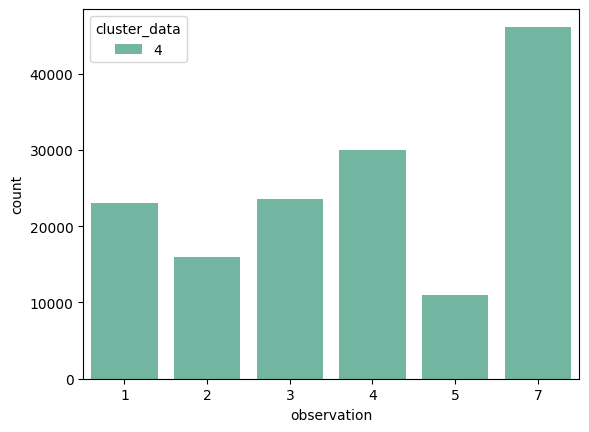

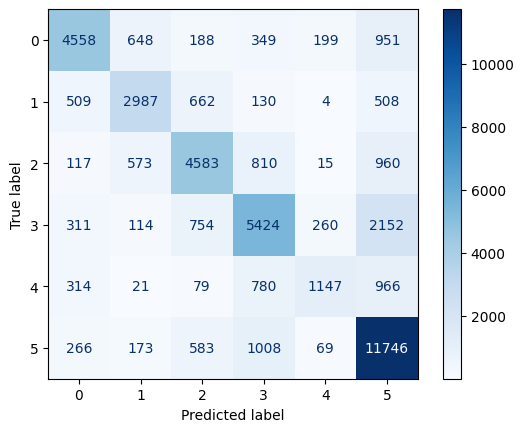

{'average_accuracy': 0.6756705658985928, 'average_f1_macro': np.float64(0.6363370944519491), 'average_f1_micro': np.float64(0.6756705658985928), 'average_auc': np.float64(0.9072456406195311), 'average_acc_kelas_generatif': 0.6483892807893545, 'average_acc_fase_padi': 0.6285348957340382}
{'val_accuracy': 0.6777906407230955, 'val_f1_macro': np.float64(0.6393390119057748), 'val_f1_micro': np.float64(0.6777906407230955), 'val_auc': np.float64(0.9076727955265835), 'val_acc_kelas_generatif': 0.6493340889770474, 'val_acc_fase_padi': 0.6321400273716056, 'val_relative_acc': np.float64(94.79949874686717)}
CLUSTER:  5


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 1 2 5 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.71      0.74      4553
           1       0.73      0.68      0.70      3592
           2       0.74      0.73      0.73      5408
           3       0.69      0.72      0.70      5685
           4       0.76      0.45      0.56      2130
           5       0.75      0.89      0.82      7875

    accuracy                           0.74     29243
   macro avg       0.74      0.69      0.71     29243
weighted avg       0.74      0.74      0.73     29243



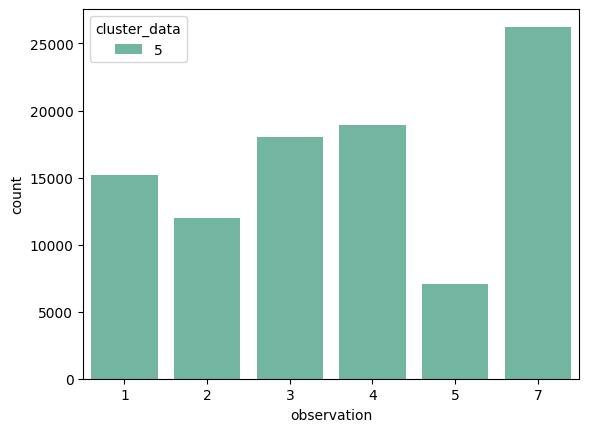

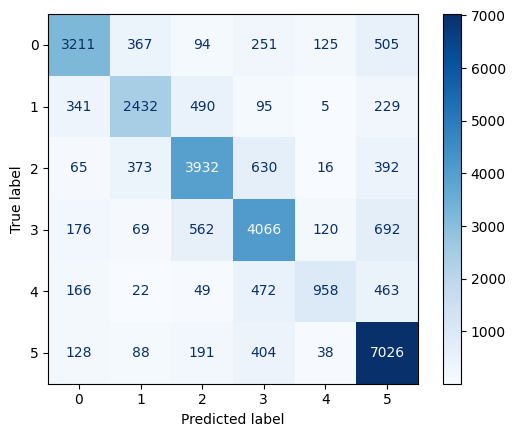

{'average_accuracy': 0.7390227168072473, 'average_f1_macro': np.float64(0.7091117210982293), 'average_f1_micro': np.float64(0.7390227168072473), 'average_auc': np.float64(0.9401868831218622), 'average_acc_kelas_generatif': 0.7286204321195869, 'average_acc_fase_padi': 0.7096931881040612}
{'val_accuracy': 0.7394932120507471, 'val_f1_macro': np.float64(0.7100941366368367), 'val_f1_micro': np.float64(0.7394932120507471), 'val_auc': np.float64(0.9412743200337844), 'val_acc_kelas_generatif': 0.7270710059171598, 'val_acc_fase_padi': 0.7090653914128288, 'val_relative_acc': np.float64(95.5886205270603)}
CLUSTER:  3


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 3 2 1 5 4]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      3540
           1       0.70      0.68      0.69      2872
           2       0.70      0.75      0.72      4808
           3       0.69      0.76      0.72      6368
           4       0.72      0.36      0.48      1545
           5       0.66      0.72      0.69      4380

    accuracy                           0.70     23513
   macro avg       0.71      0.66      0.67     23513
weighted avg       0.70      0.70      0.70     23513



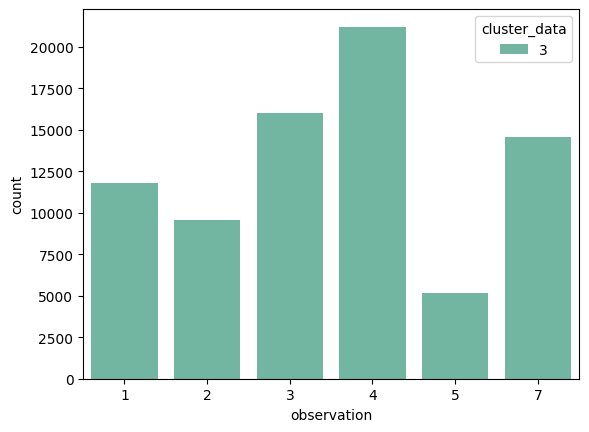

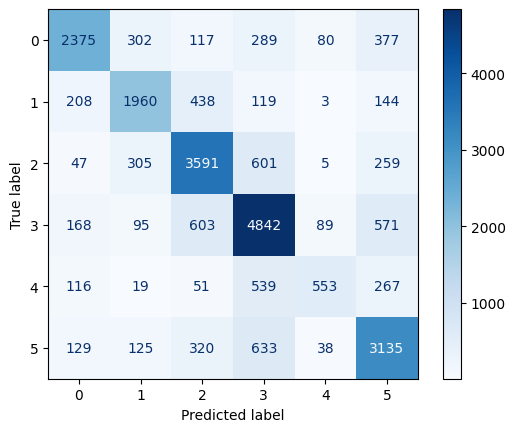

{'average_accuracy': 0.7005577987317093, 'average_f1_macro': np.float64(0.6706319959380302), 'average_f1_micro': np.float64(0.7005577987317093), 'average_auc': np.float64(0.9263051825421836), 'average_acc_kelas_generatif': 0.7418202639544853, 'average_acc_fase_padi': 0.724638858427088}
{'val_accuracy': 0.6998681580402331, 'val_f1_macro': np.float64(0.6705347616533418), 'val_f1_micro': np.float64(0.6998681580402331), 'val_auc': np.float64(0.9261645811242089), 'val_acc_kelas_generatif': 0.7468801996672213, 'val_acc_fase_padi': 0.7259495110302479, 'val_relative_acc': np.float64(94.78732514987153)}
CLUSTER:  2
[2 5 7 1 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      2647
           1       0.75      0.72      0.74      1837
           2       0.80      0.80      0.80      2325
           3       0.76      0.72      0.74      2655
           4       0.72      0.55      0.63      1313
           5       0.65      0.79      0.71      2543

    accuracy                           0.74     13320
   macro avg       0.74      0.73      0.73     13320
weighted avg       0.75      0.74      0.74     13320



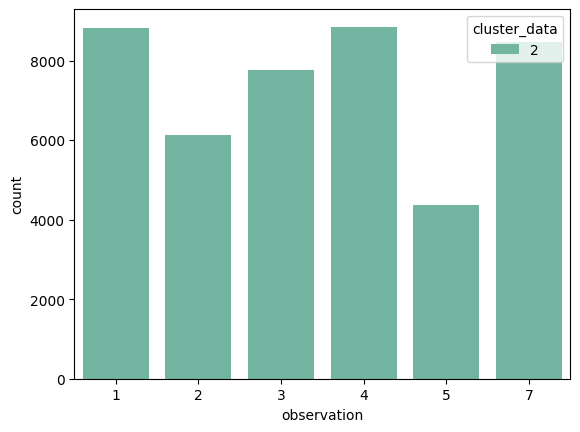

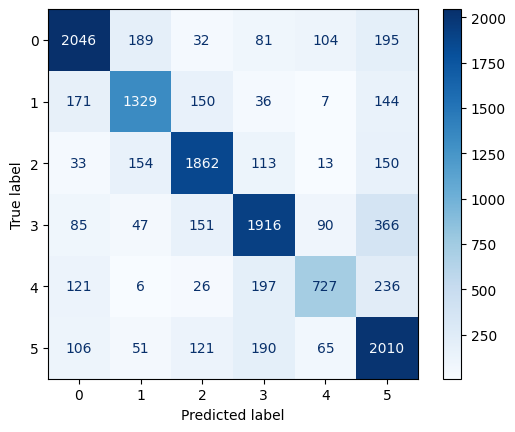

{'average_accuracy': 0.7426319176319176, 'average_f1_macro': np.float64(0.7339851345209574), 'average_f1_micro': np.float64(0.7426319176319176), 'average_auc': np.float64(0.9500070586496692), 'average_acc_kelas_generatif': 0.7924423963133641, 'average_acc_fase_padi': 0.7553202355646531}
{'val_accuracy': 0.7424924924924925, 'val_f1_macro': np.float64(0.7328443298544324), 'val_f1_micro': np.float64(0.7424924924924925), 'val_auc': np.float64(0.9503003283719019), 'val_acc_kelas_generatif': 0.8008602150537635, 'val_acc_fase_padi': 0.7558114961961115, 'val_relative_acc': np.float64(96.22135040264298)}
CLUSTER:  1


/tmp/ipykernel_851377/2909208972.py:4: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 3 5 7 4]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     10597
           1       0.80      0.81      0.80      8872
           2       0.82      0.83      0.83     12743
           3       0.84      0.87      0.86     15225
           4       0.84      0.79      0.82      6863
           5       0.58      0.37      0.45      1125

    accuracy                           0.84     55425
   macro avg       0.80      0.76      0.77     55425
weighted avg       0.83      0.84      0.83     55425



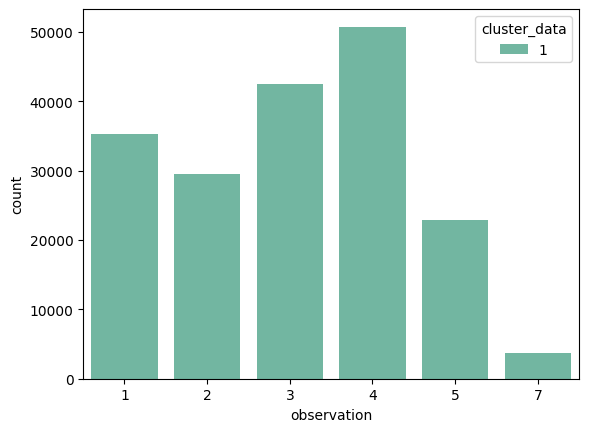

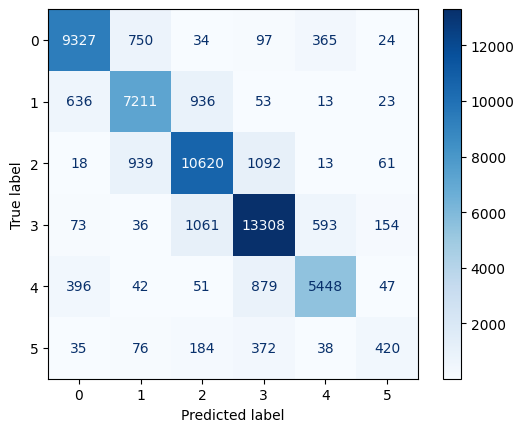

{'average_accuracy': 0.8374096269089503, 'average_f1_macro': np.float64(0.776153621250585), 'average_f1_micro': np.float64(0.8374096269089503), 'average_auc': np.float64(0.9781329957314782), 'average_acc_kelas_generatif': 0.8376158137773905, 'average_acc_fase_padi': 0.8554495534552441}
{'val_accuracy': 0.8359765448804691, 'val_f1_macro': np.float64(0.7743775150983147), 'val_f1_micro': np.float64(0.8359765448804691), 'val_auc': np.float64(0.9770052847822628), 'val_acc_kelas_generatif': 0.8333987287138036, 'val_acc_fase_padi': 0.8530471994434724, 'val_relative_acc': np.float64(99.2035709655313)}


In [17]:
for i in data_cluster.cluster_data.unique():
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded)
    print(training_metrics0)
    print(validation_metrics0)

## Running Model by Cluster

In [18]:
df=pd.read_pickle('/data/ksa/04_Data_Preprocessing/training-test/32/training_32_VH_unrecode_imputation_var20_cluster.pkl')

In [20]:
df['observation']=df.observation.apply(lambda y: 7 if int(y)>7 else int(y))

/tmp/ipykernel_851377/2727667970.py:1: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))


<Axes: xlabel='observation', ylabel='count'>

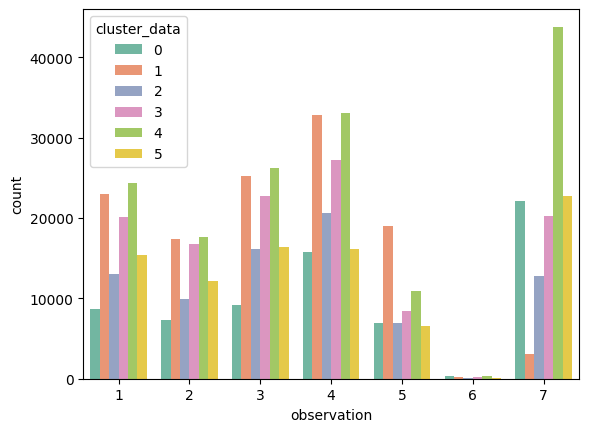

In [21]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))

CLUSTER:  0


/tmp/ipykernel_851377/3686805867.py:6: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 5 1 2 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      2602
           1       0.76      0.70      0.73      2190
           2       0.77      0.72      0.74      2768
           3       0.78      0.75      0.76      4725
           4       0.84      0.61      0.70      2085
           5       0.77      0.91      0.84      6623

    accuracy                           0.79     20993
   macro avg       0.79      0.75      0.77     20993
weighted avg       0.79      0.79      0.78     20993



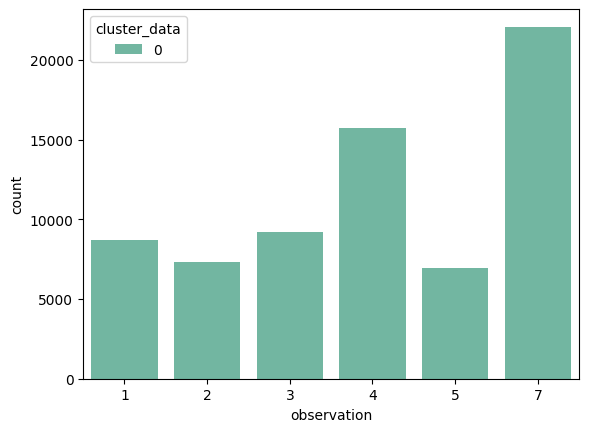

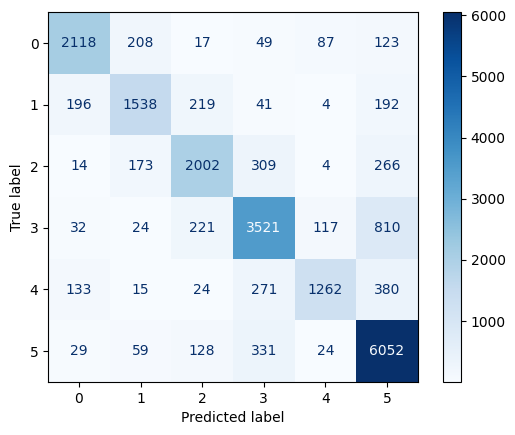

{'average_accuracy': 0.7855335795205347, 'average_f1_macro': np.float64(0.767813383002659), 'average_f1_micro': np.float64(0.7855335795205347), 'average_auc': np.float64(0.9534097294925081), 'average_acc_kelas_generatif': 0.717822481432542, 'average_acc_fase_padi': 0.7441828013256584}
{'val_accuracy': 0.7856428333253942, 'val_f1_macro': np.float64(0.7676829038734594), 'val_f1_micro': np.float64(0.7856428333253942), 'val_auc': np.float64(0.9553389951817809), 'val_acc_kelas_generatif': 0.7232658959537572, 'val_acc_fase_padi': 0.7471713471713471, 'val_relative_acc': np.float64(98.22208111754901)}
CLUSTER:  4


/tmp/ipykernel_851377/3686805867.py:6: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[3 2 7 4 5 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      7305
           1       0.66      0.61      0.63      5273
           2       0.67      0.66      0.67      7875
           3       0.65      0.62      0.64      9923
           4       0.65      0.34      0.45      3262
           5       0.67      0.84      0.75     13140

    accuracy                           0.67     46778
   macro avg       0.67      0.62      0.64     46778
weighted avg       0.67      0.67      0.67     46778



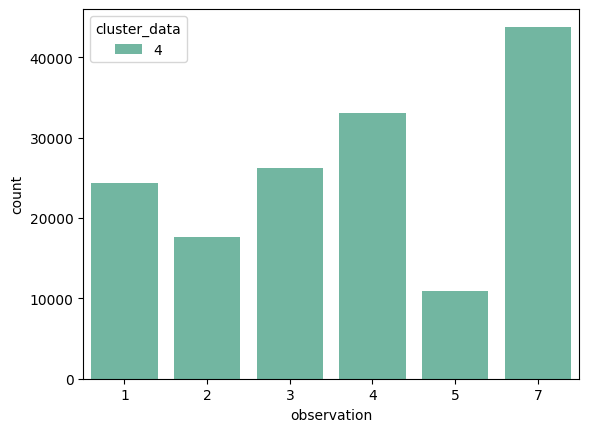

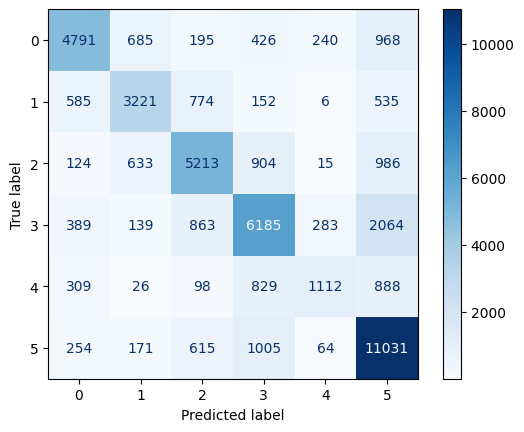

{'average_accuracy': 0.6691617930540652, 'average_f1_macro': np.float64(0.6321403588679455), 'average_f1_micro': np.float64(0.6691617930540652), 'average_auc': np.float64(0.9060621372990489), 'average_acc_kelas_generatif': 0.6533333333333334, 'average_acc_fase_padi': 0.6325310177439427}
{'val_accuracy': 0.6745264868100389, 'val_f1_macro': np.float64(0.6377549071161773), 'val_f1_micro': np.float64(0.6745264868100389), 'val_auc': np.float64(0.9075213764022663), 'val_acc_kelas_generatif': 0.661968253968254, 'val_acc_fase_padi': 0.6389913089281012, 'val_relative_acc': np.float64(94.43203177643012)}
CLUSTER:  5


/tmp/ipykernel_851377/3686805867.py:6: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 1 2 5 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      4620
           1       0.73      0.69      0.71      3637
           2       0.75      0.73      0.74      4920
           3       0.68      0.72      0.70      4853
           4       0.78      0.44      0.56      1950
           5       0.75      0.90      0.81      6818

    accuracy                           0.74     26798
   macro avg       0.75      0.70      0.71     26798
weighted avg       0.74      0.74      0.74     26798



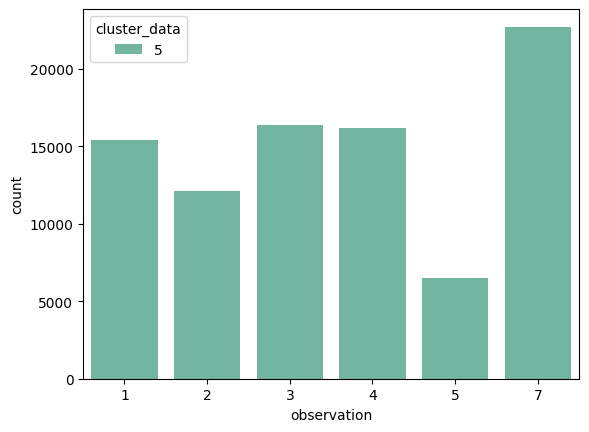

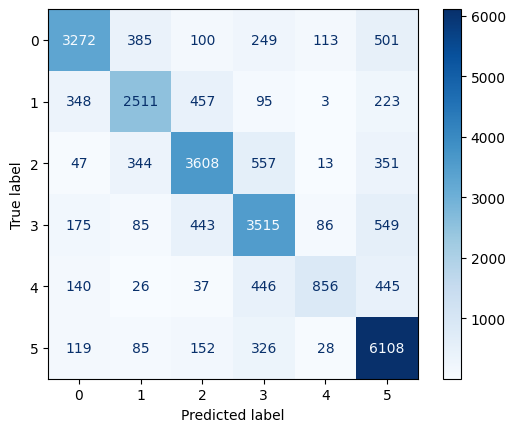

{'average_accuracy': 0.7416156288164408, 'average_f1_macro': np.float64(0.714204207161674), 'average_f1_micro': np.float64(0.7416156288164408), 'average_auc': np.float64(0.9425241797722634), 'average_acc_kelas_generatif': 0.7346689895470384, 'average_acc_fase_padi': 0.7151652008557168}
{'val_accuracy': 0.7414732442719606, 'val_f1_macro': np.float64(0.7132182218640742), 'val_f1_micro': np.float64(0.7414732442719606), 'val_auc': np.float64(0.9423910537225796), 'val_acc_kelas_generatif': 0.7333333333333333, 'val_acc_fase_padi': 0.7158069883527455, 'val_relative_acc': np.float64(95.36597621573335)}
CLUSTER:  3


/tmp/ipykernel_851377/3686805867.py:6: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 2 4 3 1 5]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      6052
           1       0.68      0.68      0.68      5048
           2       0.68      0.70      0.69      6832
           3       0.67      0.71      0.69      8168
           4       0.67      0.35      0.45      2535
           5       0.61      0.71      0.66      6075

    accuracy                           0.67     34710
   macro avg       0.67      0.64      0.65     34710
weighted avg       0.67      0.67      0.67     34710



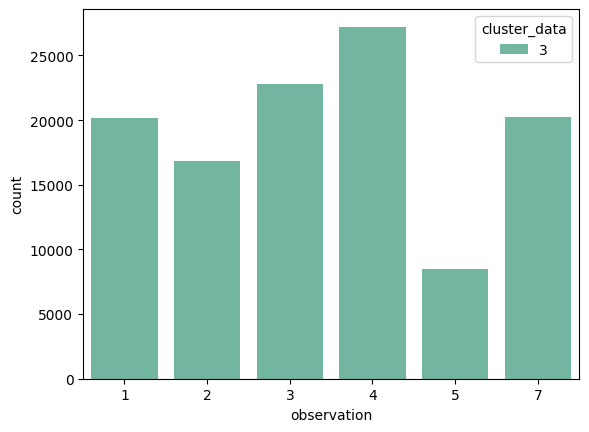

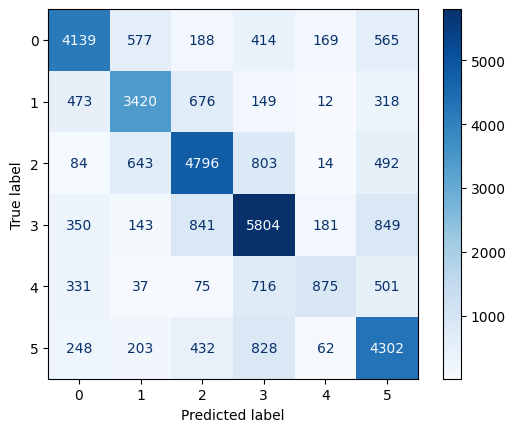

{'average_accuracy': 0.6759353006544019, 'average_f1_macro': np.float64(0.6495212155496282), 'average_f1_micro': np.float64(0.6759353006544019), 'average_auc': np.float64(0.9171250530779748), 'average_acc_kelas_generatif': 0.7140441204532676, 'average_acc_fase_padi': 0.6996223316912972}
{'val_accuracy': 0.6723134543359263, 'val_f1_macro': np.float64(0.6467046629855608), 'val_f1_micro': np.float64(0.6723134543359263), 'val_auc': np.float64(0.9159484408238402), 'val_acc_kelas_generatif': 0.7019906323185011, 'val_acc_fase_padi': 0.6957471264367816, 'val_relative_acc': np.float64(94.34195291393284)}
CLUSTER:  2


/tmp/ipykernel_851377/3686805867.py:6: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[2 5 4 7 3 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      3915
           1       0.72      0.67      0.69      2977
           2       0.78      0.78      0.78      4860
           3       0.71      0.74      0.72      6188
           4       0.70      0.50      0.58      2070
           5       0.58      0.68      0.63      3848

    accuracy                           0.71     23858
   macro avg       0.71      0.68      0.69     23858
weighted avg       0.71      0.71      0.71     23858



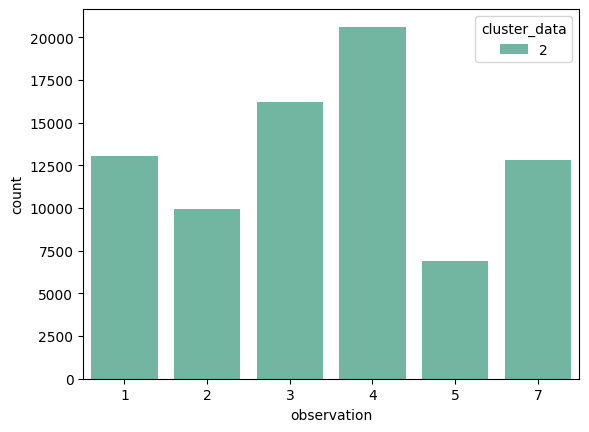

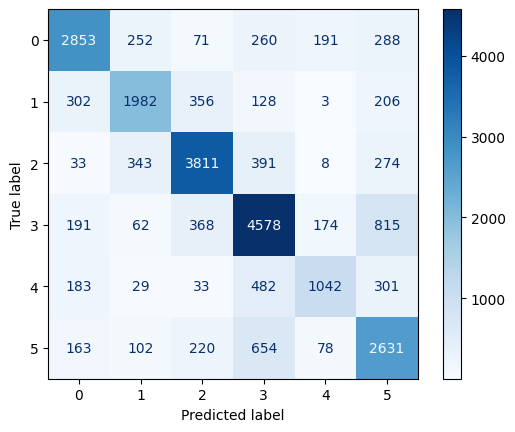

{'average_accuracy': 0.7107082256146516, 'average_f1_macro': np.float64(0.6951452868398184), 'average_f1_micro': np.float64(0.7107082256146516), 'average_auc': np.float64(0.9376664321750307), 'average_acc_kelas_generatif': 0.7784832451499119, 'average_acc_fase_padi': 0.737721097250104}
{'val_accuracy': 0.7082320395674407, 'val_f1_macro': np.float64(0.692746716671452), 'val_f1_micro': np.float64(0.7082320395674407), 'val_auc': np.float64(0.9369684763273692), 'val_acc_kelas_generatif': 0.7841563786008231, 'val_acc_fase_padi': 0.737123745819398, 'val_relative_acc': np.float64(95.48714553679797)}
CLUSTER:  1


/tmp/ipykernel_851377/3686805867.py:6: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 3 5 7 4]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6885
           1       0.83      0.83      0.83      5220
           2       0.84      0.85      0.85      7552
           3       0.86      0.88      0.87      9840
           4       0.87      0.85      0.86      5700
           5       0.60      0.49      0.54       923

    accuracy                           0.86     36120
   macro avg       0.82      0.80      0.81     36120
weighted avg       0.85      0.86      0.85     36120



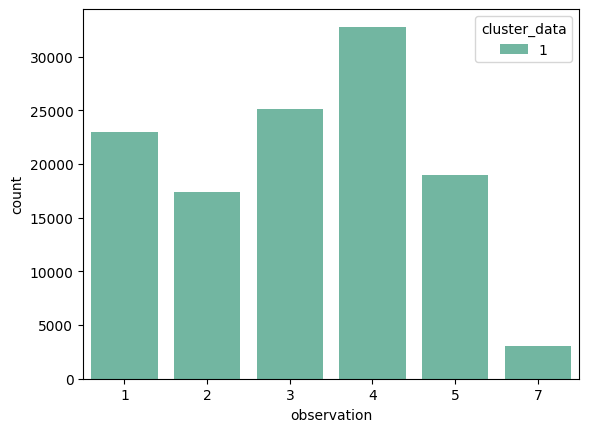

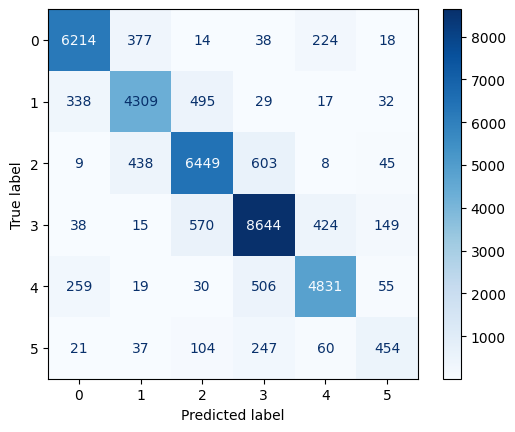

{'average_accuracy': 0.8573564309444708, 'average_f1_macro': np.float64(0.8091147453067074), 'average_f1_micro': np.float64(0.8573564309444708), 'average_auc': np.float64(0.9824689843265946), 'average_acc_kelas_generatif': 0.8499125590681125, 'average_acc_fase_padi': 0.870038406980796}
{'val_accuracy': 0.8555094130675526, 'val_f1_macro': np.float64(0.807691452048284), 'val_f1_micro': np.float64(0.8555094130675526), 'val_auc': np.float64(0.9820759997045706), 'val_acc_kelas_generatif': 0.8539459745762712, 'val_acc_fase_padi': 0.8684272976912907, 'val_relative_acc': np.float64(99.37818786176858)}


In [22]:
df['observation']=df['observation'].apply(lambda y: int(y))
df=df.query('observation!=6')
for i in data_cluster.cluster_data.unique():
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded)
    print(training_metrics0)
    print(validation_metrics0)

CLUSTER:  0


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 5 1 2 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2602
           1       0.76      0.70      0.73      2190
           2       0.76      0.71      0.73      2768
           3       0.77      0.74      0.76      4725
           4       0.84      0.61      0.71      2085
           5       0.77      0.91      0.84      6623

    accuracy                           0.78     20993
   macro avg       0.79      0.75      0.77     20993
weighted avg       0.79      0.78      0.78     20993



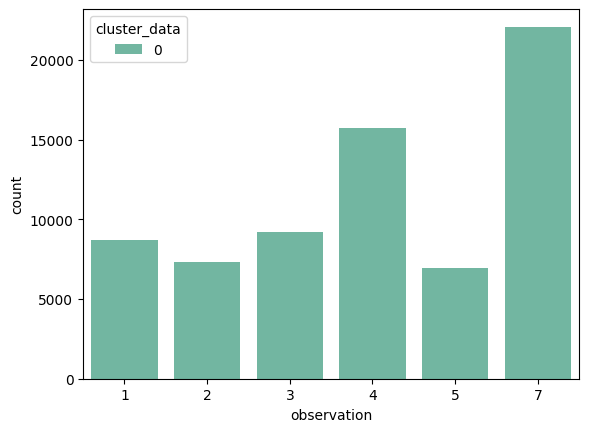

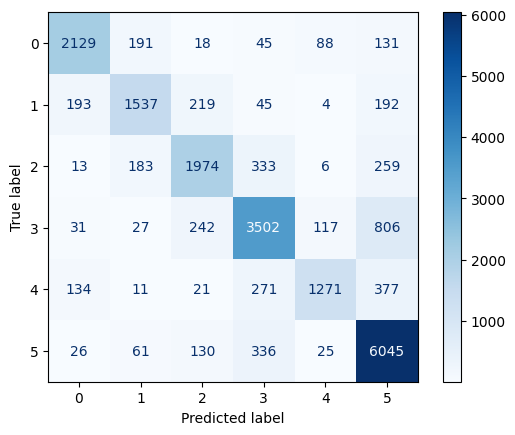

{'average_accuracy': 0.7846964364763123, 'average_f1_macro': np.float64(0.7670548738547336), 'average_f1_micro': np.float64(0.7846964364763123), 'average_auc': np.float64(0.9533379802142823), 'average_acc_kelas_generatif': 0.7125581244769097, 'average_acc_fase_padi': 0.7439037153322867}
{'val_accuracy': 0.783975610917925, 'val_f1_macro': np.float64(0.766391107670409), 'val_f1_micro': np.float64(0.783975610917925), 'val_auc': np.float64(0.9542119087419435), 'val_acc_kelas_generatif': 0.713150289017341, 'val_acc_fase_padi': 0.7441595441595441, 'val_relative_acc': np.float64(98.24672748909163)}
CLUSTER:  4


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[3 2 7 4 5 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      7305
           1       0.66      0.61      0.64      5273
           2       0.67      0.66      0.67      7875
           3       0.65      0.62      0.63      9923
           4       0.64      0.34      0.44      3262
           5       0.67      0.84      0.74     13140

    accuracy                           0.67     46778
   macro avg       0.67      0.62      0.64     46778
weighted avg       0.67      0.67      0.67     46778



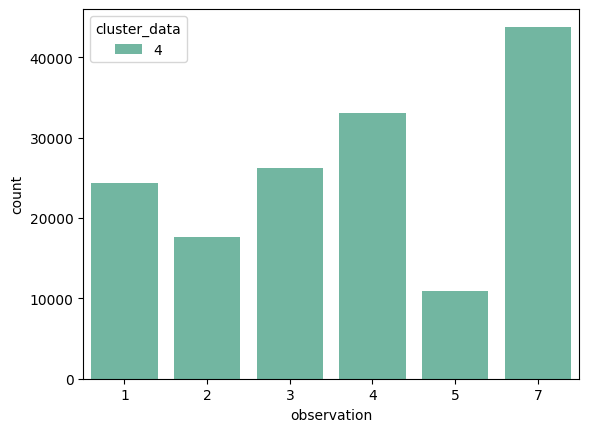

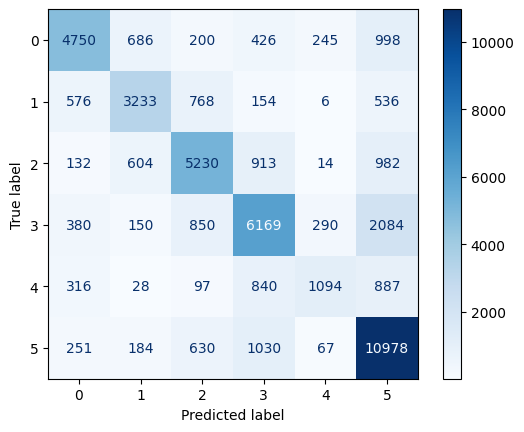

{'average_accuracy': 0.669693174828452, 'average_f1_macro': np.float64(0.6323261840931814), 'average_f1_micro': np.float64(0.669693174828452), 'average_auc': np.float64(0.905926013886646), 'average_acc_kelas_generatif': 0.6548571428571428, 'average_acc_fase_padi': 0.6333069900448669}
{'val_accuracy': 0.6724101073154046, 'val_f1_macro': np.float64(0.6355308301317893), 'val_f1_micro': np.float64(0.6724101073154046), 'val_auc': np.float64(0.9071140412591586), 'val_acc_kelas_generatif': 0.6641269841269841, 'val_acc_fase_padi': 0.638069528575191, 'val_relative_acc': np.float64(94.36254484742993)}
CLUSTER:  5


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 1 2 5 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      4620
           1       0.73      0.69      0.71      3637
           2       0.75      0.73      0.74      4920
           3       0.68      0.72      0.70      4853
           4       0.77      0.44      0.56      1950
           5       0.75      0.89      0.81      6818

    accuracy                           0.74     26798
   macro avg       0.75      0.70      0.71     26798
weighted avg       0.74      0.74      0.74     26798



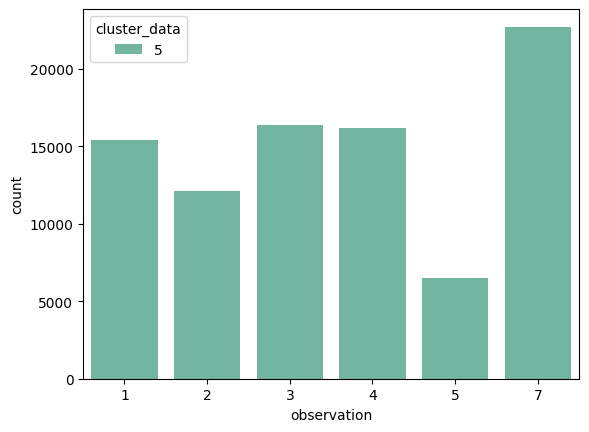

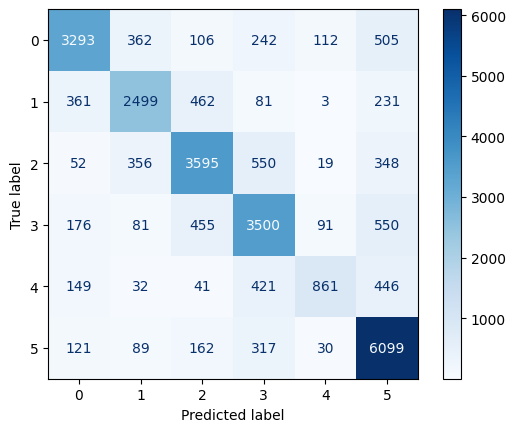

{'average_accuracy': 0.7429270338881879, 'average_f1_macro': np.float64(0.7158007214174632), 'average_f1_micro': np.float64(0.7429270338881879), 'average_auc': np.float64(0.9428141054321036), 'average_acc_kelas_generatif': 0.7360627177700347, 'average_acc_fase_padi': 0.7165200855716662}
{'val_accuracy': 0.7406149712665124, 'val_f1_macro': np.float64(0.7124640293834821), 'val_f1_micro': np.float64(0.7406149712665124), 'val_auc': np.float64(0.9420388497816415), 'val_acc_kelas_generatif': 0.7306910569105691, 'val_acc_fase_padi': 0.714753189129229, 'val_relative_acc': np.float64(95.3463687150838)}
CLUSTER:  3


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 2 4 3 1 5]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      6052
           1       0.68      0.67      0.68      5048
           2       0.68      0.71      0.69      6832
           3       0.67      0.72      0.69      8168
           4       0.66      0.34      0.45      2535
           5       0.62      0.71      0.66      6075

    accuracy                           0.67     34710
   macro avg       0.67      0.64      0.65     34710
weighted avg       0.67      0.67      0.67     34710



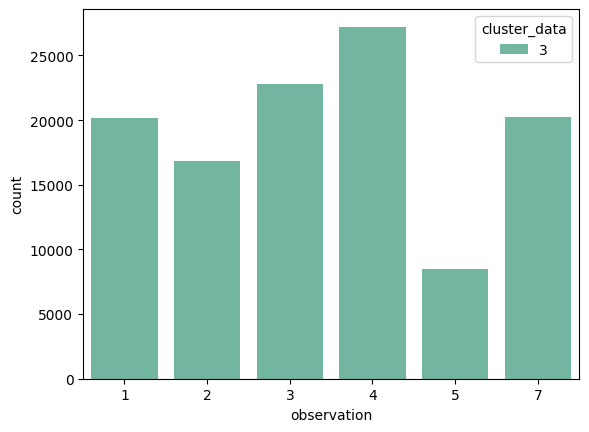

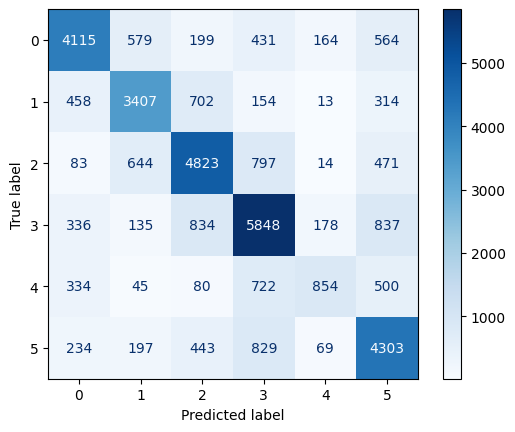

{'average_accuracy': 0.6765279664156069, 'average_f1_macro': np.float64(0.6503159194780889), 'average_f1_micro': np.float64(0.6765279664156069), 'average_auc': np.float64(0.9166100394804557), 'average_acc_kelas_generatif': 0.7127266013621951, 'average_acc_fase_padi': 0.6992939244663383}
{'val_accuracy': 0.672716796312302, 'val_f1_macro': np.float64(0.6458100787129281), 'val_f1_micro': np.float64(0.672716796312302), 'val_auc': np.float64(0.9156432837095315), 'val_acc_kelas_generatif': 0.7059426229508197, 'val_acc_fase_padi': 0.6970498084291188, 'val_relative_acc': np.float64(94.2579675517361)}
CLUSTER:  2


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[2 5 4 7 3 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74      3915
           1       0.72      0.67      0.69      2977
           2       0.79      0.79      0.79      4860
           3       0.71      0.74      0.72      6188
           4       0.70      0.50      0.58      2070
           5       0.58      0.68      0.63      3848

    accuracy                           0.71     23858
   macro avg       0.71      0.68      0.69     23858
weighted avg       0.71      0.71      0.71     23858



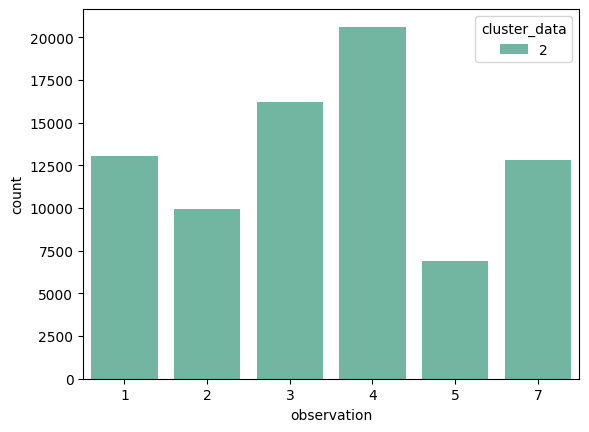

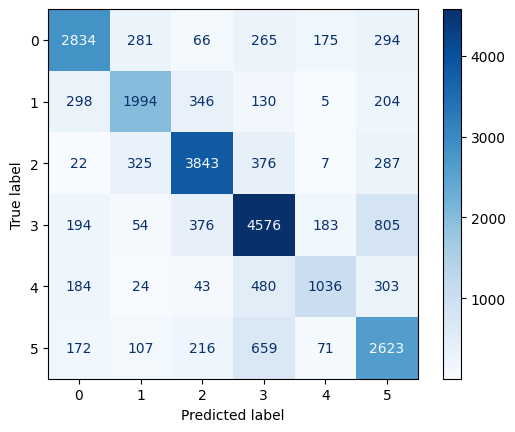

{'average_accuracy': 0.7105285520881148, 'average_f1_macro': np.float64(0.6949467744629814), 'average_f1_micro': np.float64(0.7105285520881148), 'average_auc': np.float64(0.9376273071135579), 'average_acc_kelas_generatif': 0.7794532627865961, 'average_acc_fase_padi': 0.7382704536487161}
{'val_accuracy': 0.7086092715231788, 'val_f1_macro': np.float64(0.6929723118669631), 'val_f1_micro': np.float64(0.7086092715231788), 'val_auc': np.float64(0.936892232964679), 'val_acc_kelas_generatif': 0.7907407407407407, 'val_acc_fase_padi': 0.7384057971014493, 'val_relative_acc': np.float64(95.52906110283159)}
CLUSTER:  1


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 3 5 7 4]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6885
           1       0.83      0.83      0.83      5220
           2       0.84      0.85      0.85      7552
           3       0.86      0.88      0.87      9840
           4       0.88      0.85      0.86      5700
           5       0.61      0.49      0.54       923

    accuracy                           0.86     36120
   macro avg       0.82      0.80      0.81     36120
weighted avg       0.86      0.86      0.86     36120



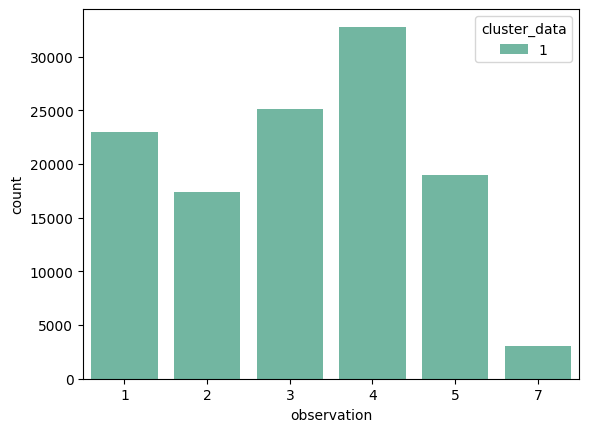

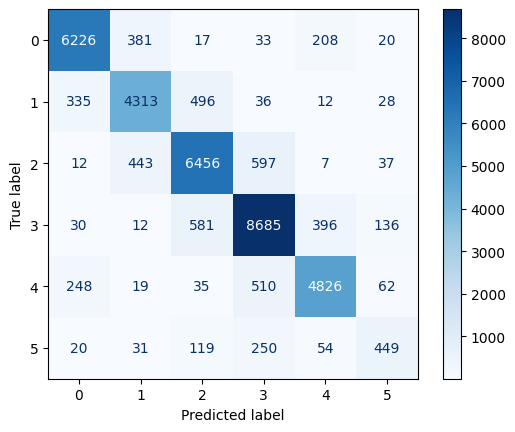

{'average_accuracy': 0.8567869008068344, 'average_f1_macro': np.float64(0.8093179904238414), 'average_f1_micro': np.float64(0.8567869008068344), 'average_auc': np.float64(0.9824938234413635), 'average_acc_kelas_generatif': 0.8492316275025962, 'average_acc_fase_padi': 0.8697187556912936}
{'val_accuracy': 0.8570044296788483, 'val_f1_macro': np.float64(0.809042876777954), 'val_f1_micro': np.float64(0.8570044296788483), 'val_auc': np.float64(0.9820962022762814), 'val_acc_kelas_generatif': 0.8548728813559322, 'val_acc_fase_padi': 0.87059700986541, 'val_relative_acc': np.float64(99.38992954115828)}


In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
df=df.query('observation!=6')
for i in data_cluster.cluster_data.unique():
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Train and evaluate the model using the standardized features
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train_scaled_df, y_train_encoded, X_test_scaled_df, y_test_encoded)
    
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)

CLUSTER:  0


/tmp/ipykernel_851377/288138278.py:20: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 5 1 2 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2602
           1       0.69      0.61      0.65      2190
           2       0.72      0.68      0.70      2768
           3       0.74      0.71      0.72      4725
           4       0.79      0.57      0.66      2085
           5       0.70      0.83      0.76      6623

    accuracy                           0.72     20993
   macro avg       0.73      0.69      0.71     20993
weighted avg       0.73      0.72      0.72     20993



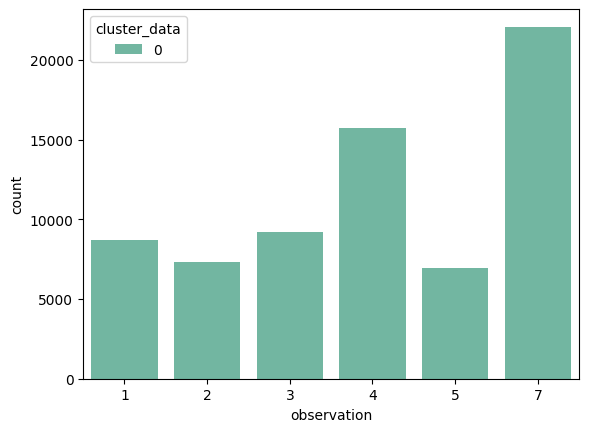

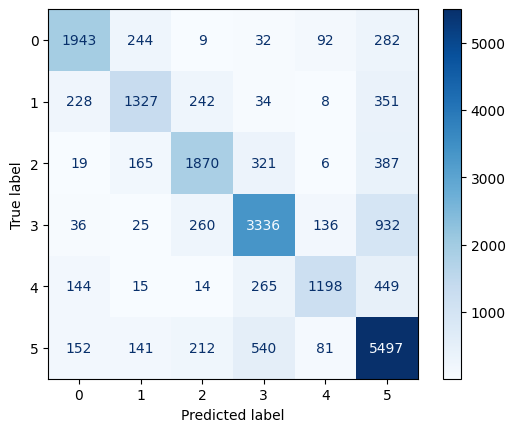

{'average_accuracy': 0.7205505114377186, 'average_f1_macro': np.float64(0.7048971956410244), 'average_f1_micro': np.float64(0.7205505114377186), 'average_auc': np.float64(0.9272279844180021), 'average_acc_kelas_generatif': 0.659126052475701, 'average_acc_fase_padi': 0.6863073434502007}
{'val_accuracy': 0.7226694612489878, 'val_f1_macro': np.float64(0.7071735981494244), 'val_f1_micro': np.float64(0.7226694612489878), 'val_auc': np.float64(0.927838506444052), 'val_acc_kelas_generatif': 0.6755780346820809, 'val_acc_fase_padi': 0.68994708994709, 'val_relative_acc': np.float64(98.34572646002172)}
CLUSTER:  4


/tmp/ipykernel_851377/288138278.py:20: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[3 2 7 4 5 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      7305
           1       0.61      0.56      0.58      5273
           2       0.64      0.61      0.63      7875
           3       0.61      0.59      0.60      9923
           4       0.58      0.32      0.41      3262
           5       0.57      0.71      0.63     13140

    accuracy                           0.61     46778
   macro avg       0.61      0.57      0.58     46778
weighted avg       0.61      0.61      0.60     46778



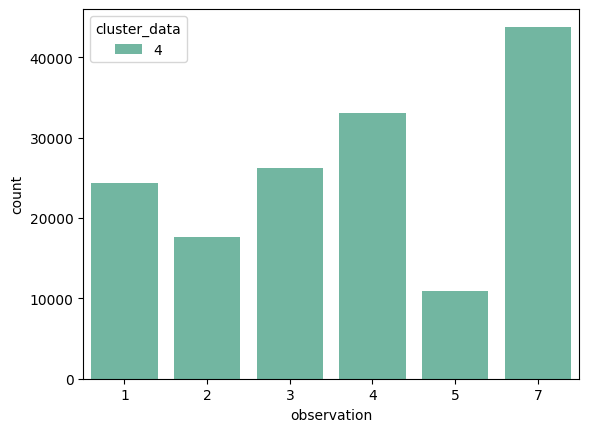

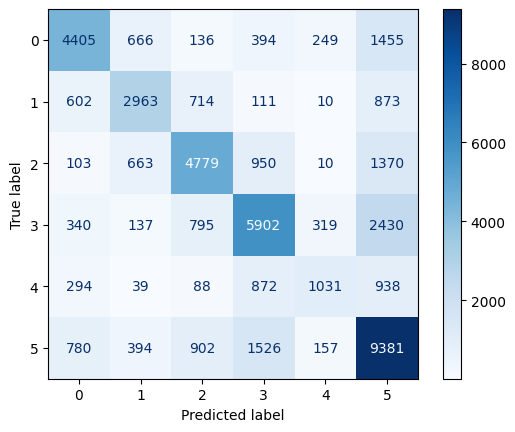

{'average_accuracy': 0.605550307561751, 'average_f1_macro': np.float64(0.577878136425061), 'average_f1_micro': np.float64(0.605550307561751), 'average_auc': np.float64(0.87293919837174), 'average_acc_kelas_generatif': 0.5979319727891157, 'average_acc_fase_padi': 0.589313417592238}
{'val_accuracy': 0.6084270383513618, 'val_f1_macro': np.float64(0.581700966706774), 'val_f1_micro': np.float64(0.6084270383513618), 'val_auc': np.float64(0.8754717169154206), 'val_acc_kelas_generatif': 0.6068571428571429, 'val_acc_fase_padi': 0.5941861996312878, 'val_relative_acc': np.float64(94.8517236188469)}
CLUSTER:  5


/tmp/ipykernel_851377/288138278.py:20: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 1 2 5 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      4620
           1       0.67      0.63      0.65      3637
           2       0.70      0.71      0.71      4920
           3       0.66      0.66      0.66      4853
           4       0.71      0.41      0.52      1950
           5       0.64      0.78      0.70      6818

    accuracy                           0.68     26798
   macro avg       0.69      0.64      0.66     26798
weighted avg       0.68      0.68      0.67     26798



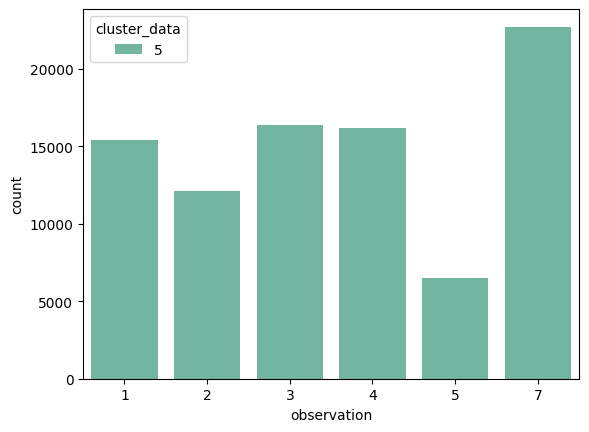

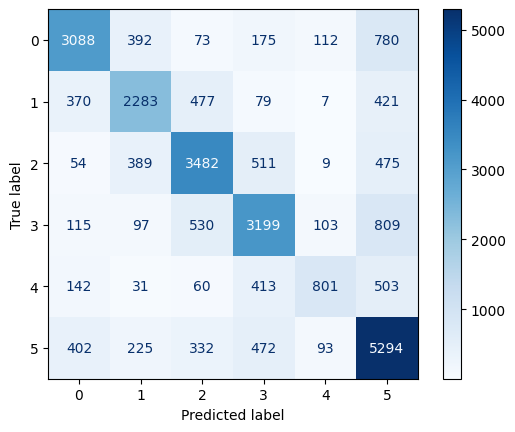

{'average_accuracy': 0.6775472711922748, 'average_f1_macro': np.float64(0.6576267698350833), 'average_f1_micro': np.float64(0.6775472711922748), 'average_auc': np.float64(0.9117359785284489), 'average_acc_kelas_generatif': 0.7011324041811846, 'average_acc_fase_padi': 0.6680770144996435}
{'val_accuracy': 0.6771774012986044, 'val_f1_macro': np.float64(0.656122489192132), 'val_f1_micro': np.float64(0.6771774012986044), 'val_auc': np.float64(0.9121155928075647), 'val_acc_kelas_generatif': 0.7077235772357724, 'val_acc_fase_padi': 0.6684414864115363, 'val_relative_acc': np.float64(95.8804143126177)}
CLUSTER:  3


/tmp/ipykernel_851377/288138278.py:20: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 2 4 3 1 5]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      6052
           1       0.64      0.64      0.64      5048
           2       0.65      0.69      0.67      6832
           3       0.63      0.69      0.66      8168
           4       0.60      0.32      0.41      2535
           5       0.52      0.55      0.53      6075

    accuracy                           0.62     34710
   macro avg       0.62      0.59      0.60     34710
weighted avg       0.62      0.62      0.62     34710



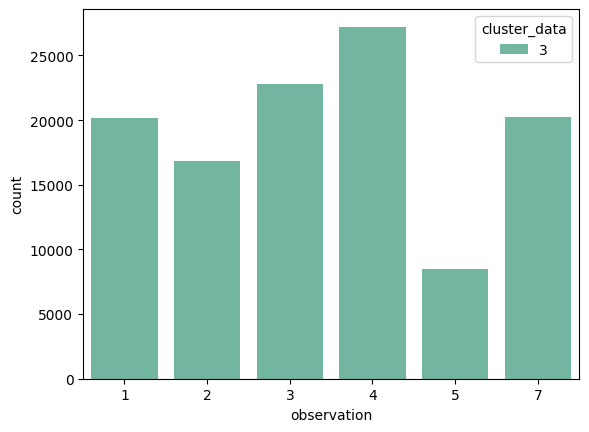

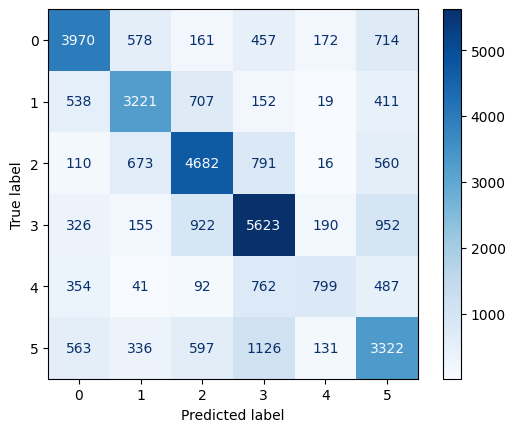

{'average_accuracy': 0.6272132362020002, 'average_f1_macro': np.float64(0.6001534643639193), 'average_f1_micro': np.float64(0.6272132362020002), 'average_auc': np.float64(0.8899242117452915), 'average_acc_kelas_generatif': 0.6975477576817738, 'average_acc_fase_padi': 0.6755172413793104}
{'val_accuracy': 0.6227888216652262, 'val_f1_macro': np.float64(0.5965718776805996), 'val_f1_micro': np.float64(0.6227888216652262), 'val_auc': np.float64(0.8887543845296523), 'val_acc_kelas_generatif': 0.685304449648712, 'val_acc_fase_padi': 0.670344827586207, 'val_relative_acc': np.float64(94.0065069969817)}
CLUSTER:  2


/tmp/ipykernel_851377/288138278.py:20: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[2 5 4 7 3 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      3915
           1       0.69      0.64      0.66      2977
           2       0.76      0.79      0.77      4860
           3       0.66      0.75      0.70      6188
           4       0.65      0.51      0.57      2070
           5       0.58      0.55      0.57      3848

    accuracy                           0.68     23858
   macro avg       0.68      0.66      0.67     23858
weighted avg       0.68      0.68      0.68     23858



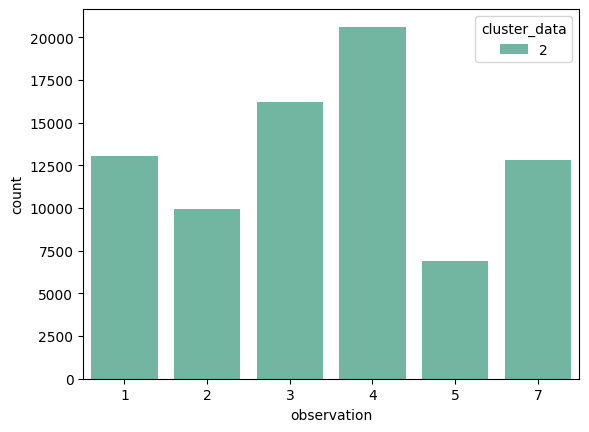

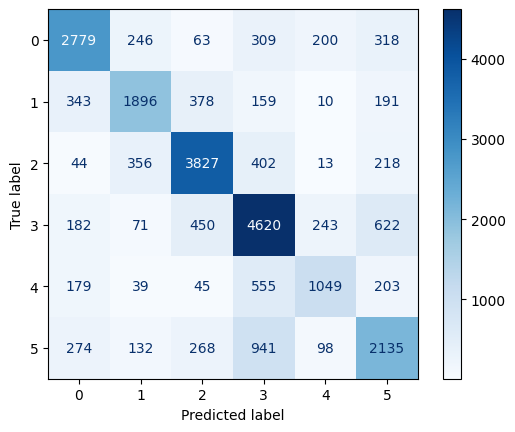

{'average_accuracy': 0.6827562271034522, 'average_f1_macro': np.float64(0.6655975375810413), 'average_f1_micro': np.float64(0.6827562271034522), 'average_auc': np.float64(0.9228990353552371), 'average_acc_kelas_generatif': 0.7686948853615521, 'average_acc_fase_padi': 0.7298852804873792}
{'val_accuracy': 0.683460474473971, 'val_f1_macro': np.float64(0.6658592925709073), 'val_f1_micro': np.float64(0.683460474473971), 'val_auc': np.float64(0.9227395139276492), 'val_acc_kelas_generatif': 0.7874485596707819, 'val_acc_fase_padi': 0.731438127090301, 'val_relative_acc': np.float64(94.93444576877235)}
CLUSTER:  1


/tmp/ipykernel_851377/288138278.py:20: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 3 5 7 4]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      6885
           1       0.80      0.81      0.80      5220
           2       0.82      0.84      0.83      7552
           3       0.85      0.87      0.86      9840
           4       0.86      0.83      0.85      5700
           5       0.62      0.30      0.40       923

    accuracy                           0.84     36120
   macro avg       0.80      0.76      0.77     36120
weighted avg       0.84      0.84      0.84     36120



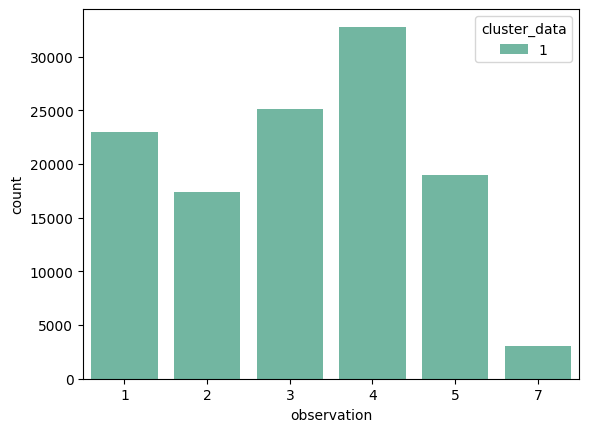

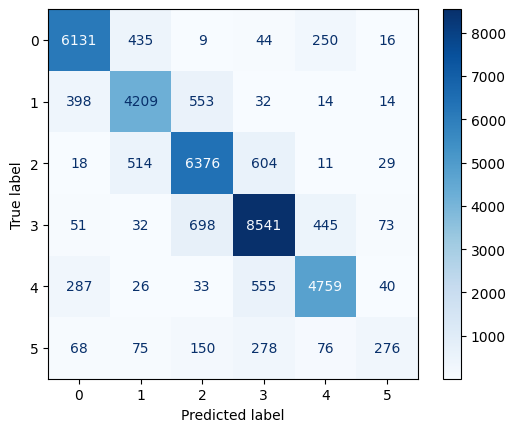

{'average_accuracy': 0.8391789273849074, 'average_f1_macro': np.float64(0.7690090266125807), 'average_f1_micro': np.float64(0.8391789273849074), 'average_auc': np.float64(0.9751372616910985), 'average_acc_kelas_generatif': 0.836804308450262, 'average_acc_fase_padi': 0.8563812092723699}
{'val_accuracy': 0.8386489479512735, 'val_f1_macro': np.float64(0.7705909089243304), 'val_f1_micro': np.float64(0.8386489479512735), 'val_auc': np.float64(0.9749753865838402), 'val_acc_kelas_generatif': 0.8442796610169492, 'val_acc_fase_padi': 0.8562565684645896, 'val_relative_acc': np.float64(99.22912205567452)}


In [30]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns

# Assuming get_train_test and evaluate_model are defined elsewhere
#VV_=[f'VV_{10-i}' for i in range(0,11)]
VH_=[f'VH_{30-i}' for i in range(0,31)]
df['observation'] = df['observation'].apply(lambda y: int(y))
df = df.query('observation != 6')

means=df[VH_].values.mean(axis=1,keepdims=True)
stds=df[VH_].values.std(axis=1,keepdims=True)
df_std=(df[VH_]-means)/stds
df_std['cluster_data']=df['cluster_data']
df_std['observation']=df['observation']
for i in data_cluster.cluster_data.unique():
    print('CLUSTER: ', i)
    df_x = df_std.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded)
    print(training_metrics0)
    print(validation_metrics0)


## RUNNING BY PRIOR SOM

In [35]:
df=pd.read_pickle('/data/ksa/04_Data_Preprocessing/32/03_som_filtering/data_with_prior_posterior.pkl').query('prior>=0.5')

/tmp/ipykernel_851377/2727667970.py:1: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))


<Axes: xlabel='observation', ylabel='count'>

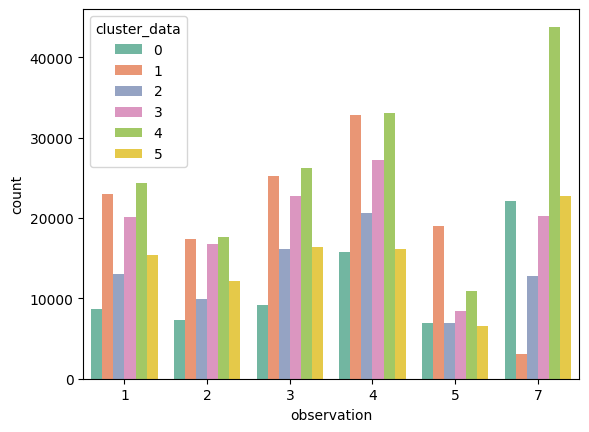

In [32]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))

/tmp/ipykernel_851377/2727667970.py:1: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))


<Axes: xlabel='observation', ylabel='count'>

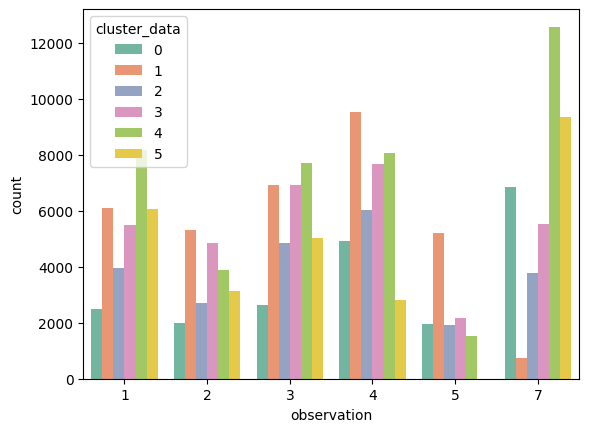

In [36]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))

CLUSTER:  0
[7 5 1 2 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       747
           1       0.77      0.70      0.73       598
           2       0.76      0.70      0.73       793
           3       0.74      0.74      0.74      1480
           4       0.89      0.60      0.71       590
           5       0.78      0.91      0.84      2055

    accuracy                           0.78      6263
   macro avg       0.80      0.74      0.76      6263
weighted avg       0.79      0.78      0.78      6263



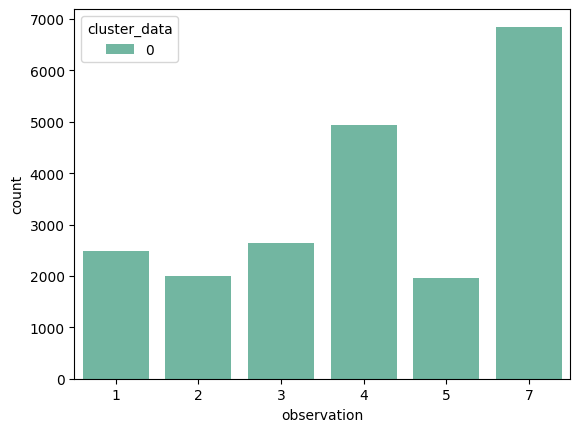

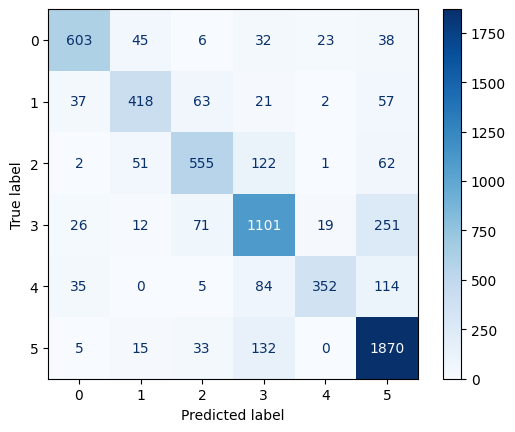

{'average_accuracy': 0.7877630340032544, 'average_f1_macro': np.float64(0.7644339784904746), 'average_f1_micro': np.float64(0.7877630340032544), 'average_auc': np.float64(0.9517877040249187), 'average_acc_kelas_generatif': 0.7113513513513514, 'average_acc_fase_padi': 0.7465346937972845}
{'val_accuracy': 0.7822129969663101, 'val_f1_macro': np.float64(0.7642398656259336), 'val_f1_micro': np.float64(0.7822129969663101), 'val_auc': np.float64(0.9503011403516727), 'val_acc_kelas_generatif': 0.699873896595208, 'val_acc_fase_padi': 0.7399115533443892, 'val_relative_acc': np.float64(97.0971242539338)}
CLUSTER:  4
[3 2 7 4 5 1]


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      2449
           1       0.75      0.69      0.72      1162
           2       0.79      0.79      0.79      2309
           3       0.71      0.68      0.70      2422
           4       0.71      0.30      0.42       456
           5       0.77      0.89      0.82      3771

    accuracy                           0.77     12569
   macro avg       0.76      0.69      0.71     12569
weighted avg       0.77      0.77      0.77     12569



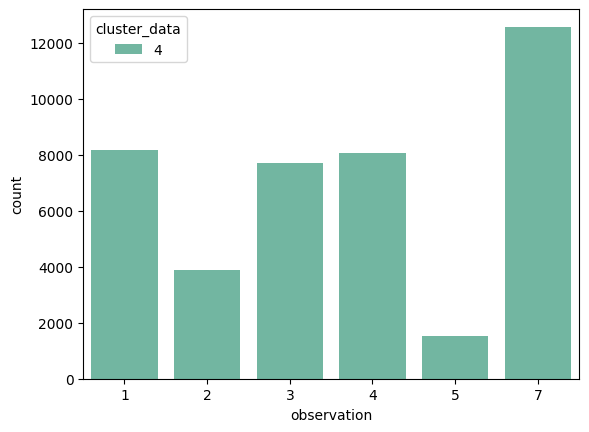

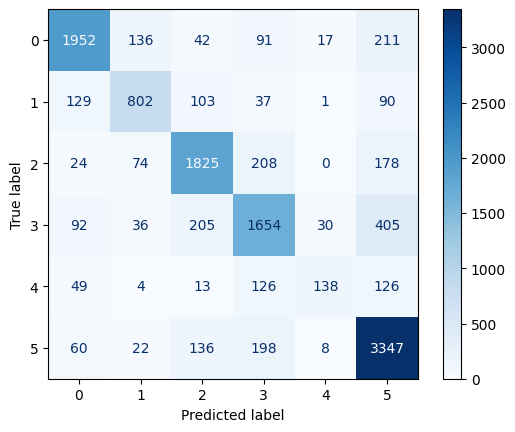

{'average_accuracy': 0.7727348637909038, 'average_f1_macro': np.float64(0.7115181781078067), 'average_f1_micro': np.float64(0.7727348637909038), 'average_auc': np.float64(0.9448041614752618), 'average_acc_kelas_generatif': 0.7834099048583728, 'average_acc_fase_padi': 0.7451305860567535}
{'val_accuracy': 0.773172090062853, 'val_f1_macro': np.float64(0.7121462200949419), 'val_f1_micro': np.float64(0.773172090062853), 'val_auc': np.float64(0.9458623913582426), 'val_acc_kelas_generatif': 0.7903854482459939, 'val_acc_fase_padi': 0.7471829297530568, 'val_relative_acc': np.float64(95.63430919363122)}
CLUSTER:  5
[7 1 2 4 3]


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(7): np.int64(4)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1814
           1       0.91      0.88      0.89       939
           2       0.94      0.93      0.94      1513
           3       0.92      0.89      0.91       842
           4       0.94      0.97      0.96      2800

    accuracy                           0.94      7908
   macro avg       0.94      0.92      0.93      7908
weighted avg       0.94      0.94      0.94      7908



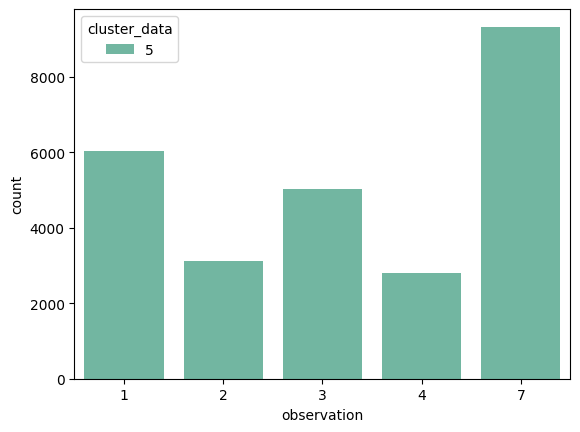

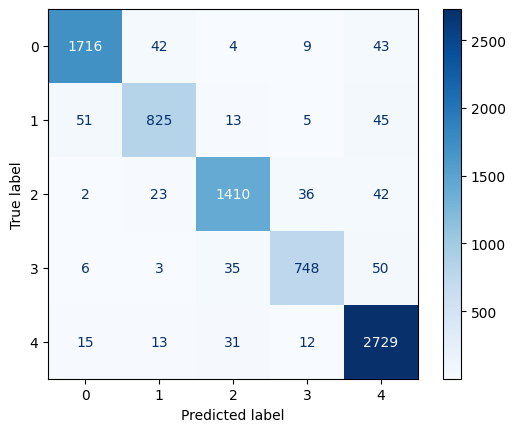

{'average_accuracy': 0.946130241362018, 'average_f1_macro': np.float64(0.9364665470465503), 'average_f1_micro': np.float64(0.946130241362018), 'average_auc': np.float64(0.9942940211726935), 'average_acc_kelas_generatif': 0.9410764872521247, 'average_acc_fase_padi': 0.9288468091937577}
{'val_accuracy': 0.9393019726858877, 'val_f1_macro': np.float64(0.9292622568655539), 'val_f1_micro': np.float64(0.9393019726858877), 'val_auc': np.float64(0.99377235033715), 'val_acc_kelas_generatif': 0.9319233311302049, 'val_acc_fase_padi': 0.9199295223179327, 'val_relative_acc': np.float64(97.97673242286292)}
CLUSTER:  3
[7 2 4 3 1 5]


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1647
           1       0.72      0.69      0.71      1452
           2       0.71      0.75      0.73      2073
           3       0.68      0.73      0.70      2296
           4       0.71      0.36      0.47       655
           5       0.62      0.68      0.65      1663

    accuracy                           0.69      9786
   macro avg       0.69      0.65      0.66      9786
weighted avg       0.69      0.69      0.68      9786



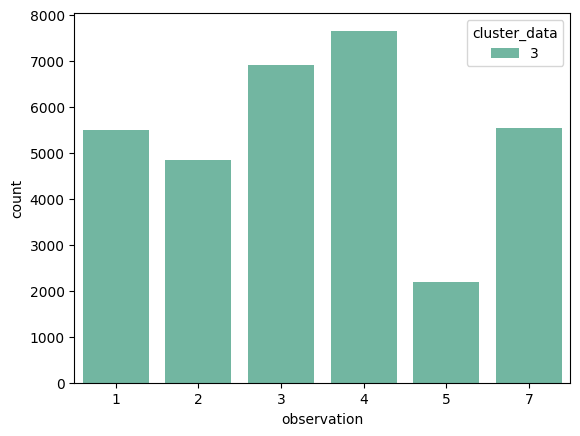

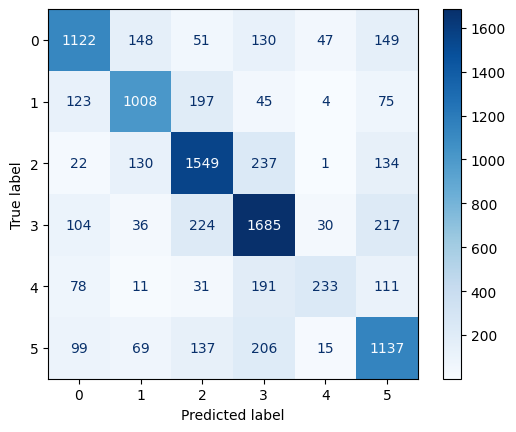

{'average_accuracy': 0.693149967184455, 'average_f1_macro': np.float64(0.6706106868403351), 'average_f1_micro': np.float64(0.693149967184455), 'average_auc': np.float64(0.9217503383589291), 'average_acc_kelas_generatif': 0.742606638919039, 'average_acc_fase_padi': 0.7137446197991391}
{'val_accuracy': 0.6881258941344778, 'val_f1_macro': np.float64(0.6607637174070762), 'val_f1_micro': np.float64(0.6881258941344778), 'val_auc': np.float64(0.9196337835797189), 'val_acc_kelas_generatif': 0.7472262421611191, 'val_acc_fase_padi': 0.7182645956079271, 'val_relative_acc': np.float64(94.15086728519564)}
CLUSTER:  2
[2 5 4 7 3 1]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1183
           1       0.69      0.69      0.69       814
           2       0.80      0.80      0.80      1457
           3       0.71      0.74      0.73      1810
           4       0.70      0.47      0.56       576
           5       0.61      0.71      0.66      1136

    accuracy                           0.71      6976
   macro avg       0.71      0.69      0.69      6976
weighted avg       0.72      0.71      0.71      6976



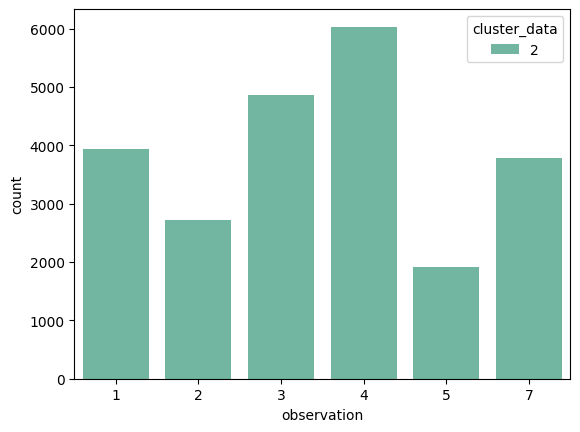

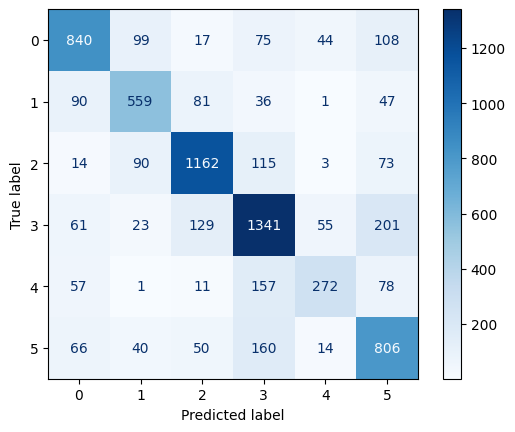

{'average_accuracy': 0.7146719090267477, 'average_f1_macro': np.float64(0.6951686626928271), 'average_f1_micro': np.float64(0.7146719090267477), 'average_auc': np.float64(0.9355583377023162), 'average_acc_kelas_generatif': 0.7829411764705883, 'average_acc_fase_padi': 0.745421013417756}
{'val_accuracy': 0.7138761467889908, 'val_f1_macro': np.float64(0.693664192615646), 'val_f1_micro': np.float64(0.7138761467889908), 'val_auc': np.float64(0.9362310033511765), 'val_acc_kelas_generatif': 0.7975291695264242, 'val_acc_fase_padi': 0.7412613981762918, 'val_relative_acc': np.float64(95.46221638852428)}
CLUSTER:  1
[1 2 3 5 7 4]


/tmp/ipykernel_851377/4277413669.py:7: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1834
           1       0.83      0.85      0.84      1591
           2       0.85      0.84      0.85      2077
           3       0.86      0.90      0.88      2861
           4       0.86      0.83      0.85      1565
           5       0.69      0.39      0.49       225

    accuracy                           0.86     10153
   macro avg       0.83      0.78      0.80     10153
weighted avg       0.86      0.86      0.86     10153



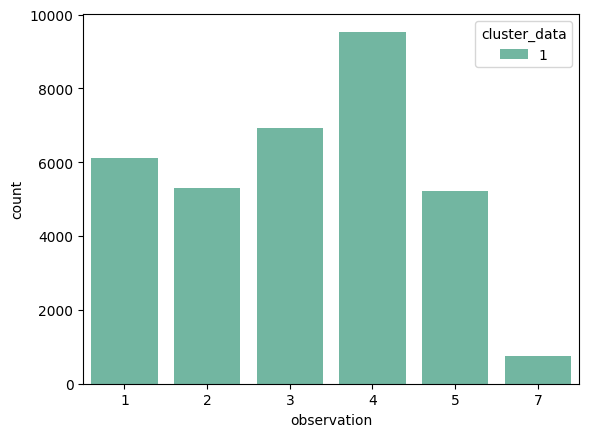

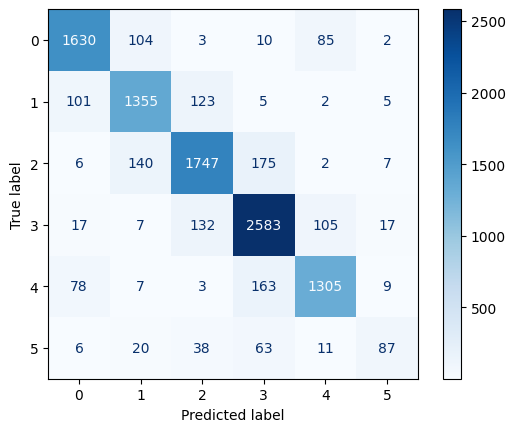

{'average_accuracy': 0.8620399051751508, 'average_f1_macro': np.float64(0.8033171397097986), 'average_f1_micro': np.float64(0.8620399051751508), 'average_auc': np.float64(0.9823901575774336), 'average_acc_kelas_generatif': 0.8524900790484397, 'average_acc_fase_padi': 0.8779278329842084}
{'val_accuracy': 0.8575790406776322, 'val_f1_macro': np.float64(0.8000800171617781), 'val_f1_micro': np.float64(0.8575790406776322), 'val_auc': np.float64(0.9822498877176195), 'val_acc_kelas_generatif': 0.8411169956668272, 'val_acc_fase_padi': 0.8746861174219778, 'val_relative_acc': np.float64(99.37297734627832)}


In [37]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
df=df.query('observation!=6')
for i in data_cluster.cluster_data.unique():
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Train and evaluate the model using the standardized features
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train_scaled_df, y_train_encoded, X_test_scaled_df, y_test_encoded)
    
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)